# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


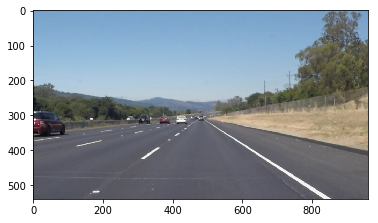

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [4]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [5]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'challenge2',
 'challenge',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

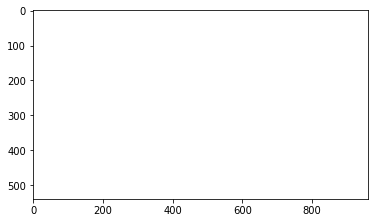

In [6]:
from IPython.display import display
from ipywidgets import widgets, interact, interactive, fixed, interact_manual
import os
import math

# interactive filter builder (features ordered by importance):
# exposes min/max range on each channel and displays them
# applys filters to image in real time
# choose initial color space transform (just choose HSV to simplify)

name = 'solidYellowCurve.jpg'
image = mpimg.imread('test_images/' + name)
input_image = image
input_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

def filter_hsv(hmin, hmax, smin, smax, vmin, vmax):
    input_copy = np.copy(input_image)
    thresholds = ((input_image[:,:,0] >= hmin) & (input_image[:,:,0] <= hmax) &
                  (input_image[:,:,1] >= smin) & (input_image[:,:,1] <= smax) &
                  (input_image[:,:,2] >= vmin) & (input_image[:,:,2] <= vmax))
    input_copy[thresholds] = [255,255,255]
    # clunky...
    inverse = ((input_image[:,:,0] < hmin) | (input_image[:,:,0] > hmax) |
               (input_image[:,:,1] < smin) | (input_image[:,:,1] > smax) |
               (input_image[:,:,2] < vmin) | (input_image[:,:,2] > vmax))
    input_copy[inverse] = [0,0,0]
    
    plt.imshow(input_copy)

# interact(f, x=10)
# color = widgets.ColorPicker(value='#000000')

interactive(filter_hsv,
            hmin=widgets.IntSlider(min=0,max=255,step=1,value=0),
            hmax=widgets.IntSlider(min=0,max=255,step=1,value=255),
            smin=widgets.IntSlider(min=0,max=255,step=1,value=0),
            smax=widgets.IntSlider(min=0,max=255,step=1,value=255),
            vmin=widgets.IntSlider(min=0,max=255,step=1,value=0),
            vmax=widgets.IntSlider(min=0,max=255,step=1,value=255))

# good yellow hsv
# hmin=13
# hmax=23
# smin=73
# smax=160
# vmin=145
# vmax=252

# good yellow hsv 2
# hmin=15
# hmax=38
# smin=28
# smax=175
# vmin=186
# vmax=255

# good yellow rbg (better than hsv)
# rmin=198
# rmax=255
# gmin=113
# gmax=255
# bmin=82
# bmax=156




In [11]:
CHALLENGE=True
suffix = 'challenge2/' if CHALLENGE else ''
input_images = [(name, mpimg.imread('test_images/' + suffix + name)) for name in os.listdir("test_images/" + suffix)]

def show_images(input_images, title='', ncols=1):
    #plt.title(title)
    nrows = math.ceil(len(input_images)/ncols)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(40,40))
    flattened = []
    for axr in axs:
        flattened.extend(axr)
    for ax, (name, image) in zip(flattened, input_images):
        ax.imshow(image)
        ax.set_title(name)
    plt.show()

'''Note: before and after are lists of (name, img) tuples'''
def show_transform(before, after, before_cmap=None, after_cmap=None, title=''):
    #plt.title(title)
    fig, axs = plt.subplots(nrows=len(before), ncols=2, squeeze=False, sharex='all', sharey='all', figsize=(12,25))
    fig.tight_layout()
    for ax, ((bname, bimg), (aname, aimg)) in zip(axs, zip(before, after)):
        if before_cmap:
            ax[0].imshow(bimg, cmap=before_cmap)
        else:
            ax[0].imshow(bimg)
        ax[0].set_title(bname)
        if after_cmap:
            ax[1].imshow(aimg, cmap=after_cmap)
        else:
            ax[1].imshow(aimg)
        ax[1].set_title(aname)
    plt.show()

'''images are (name, img) tuples'''
def save_test_output(images):
    for name, image in images:
        mpimg.imsave('test_images_output/' + name[:-4], image, format='png')
    
'''Note: before and after are lists of (name, img) tuples'''
def show_hsv_channels(images):
    #plt.title(title)
    fig, axs = plt.subplots(nrows=len(images), ncols=4, squeeze=False, sharex='all', sharey='all', figsize=(12,25))
    fig.tight_layout()
    
    chanimages = []
    for ax, (name, image) in zip(axs, images):
        color_select = np.copy(image)
        cv2.cvtColor(color_select, cv2.COLOR_RGB2HSV)
        #hue = cv2.extractChannel(color_select, 0)
        chans = cv2.split(color_select)
        ax[0].imshow(image)
        for i, chan in zip(range(len(chans)), chans):
            ax[i+1].imshow(chan, cmap='gray')
    
    plt.show()

# The tools you have are color selection, region of interest selection,
# grayscaling, Gaussian smoothing, Canny Edge Detection and Hough
# Tranform line detection.


############ color selection (select white and yellow) #############
def get_white_selected(image):
    color_select = np.copy(image)

    # Define color selection criteria
    ###### MODIFY THESE VARIABLES TO MAKE YOUR COLOR SELECTION
    WHITE_THRESHOLD = 200
    red_threshold = WHITE_THRESHOLD
    green_threshold = WHITE_THRESHOLD
    blue_threshold = WHITE_THRESHOLD
    ######

    rgb_threshold = [red_threshold, green_threshold, blue_threshold]

    # Do a boolean or with the "|" character to identify
    # pixels below the thresholds
    thresholds = (image[:,:,0] < rgb_threshold[0]) \
                | (image[:,:,1] < rgb_threshold[1]) \
                | (image[:,:,2] < rgb_threshold[2])
    color_select[thresholds] = [0,0,0]
    return color_select
    
# Grab the x and y size and make a copy of the image
white_selected = []
for (name, image) in input_images:
    color_select = get_white_selected(image)
    white_selected.append(('white_selected_'+name, color_select))
###################################################################
### find yellow lanes ###
#show_hsv_channels(input_images)

# TODO(j): refactor to generic channel names
def filter_3chan(input_image, hmin, hmax, smin, smax, vmin, vmax):
    input_copy = np.copy(input_image)
    thresholds = ((input_image[:,:,0] >= hmin) & (input_image[:,:,0] <= hmax) &
                  (input_image[:,:,1] >= smin) & (input_image[:,:,1] <= smax) &
                  (input_image[:,:,2] >= vmin) & (input_image[:,:,2] <= vmax))
    input_copy[thresholds] = [255,255,255]
    # clunky...
    inverse = ((input_image[:,:,0] < hmin) | (input_image[:,:,0] > hmax) |
               (input_image[:,:,1] < smin) | (input_image[:,:,1] > smax) |
               (input_image[:,:,2] < vmin) | (input_image[:,:,2] > vmax))
    input_copy[inverse] = [0,0,0]
    return input_copy

def get_yellow_selected(image):
    return filter_3chan(input_image=image, hmin=198,hmax=255,smin=113,smax=255,vmin=82,vmax=156)

yellow_selected = []
for (name, image) in input_images:
    yellow = get_yellow_selected(image)
    yellow_selected.append(('yellow_selected_'+name, yellow))
    
def get_merged(white_image, yellow_image):
    return np.maximum(white_image, yellow_image)

# merge white and yellow lane markers
color_selected = []
for ((white_name, white_image), (yellow_lane, yellow_image)) in zip(white_selected, yellow_selected):
    # white means selected, so just take pixels with the highest value from each image, color-wise
    color_selected.append(('merged_color_selection_'+white_name, get_merged(white_image, yellow_image)))
    
##############################################################
# apply area of interest to lanes

# TODO(j): a bit hacky
ysize = color_selected[0][1].shape[0]
xsize = color_selected[0][1].shape[1]

# original images are 960x540, new are 1280x720
left_bottom = [0, ysize-1]
right_bottom = [xsize-1, ysize-1]
apex = [xsize/2, (30/54)*ysize]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

def get_area_of_interest(image):
    region_select = np.copy(image)                
    # TODO(j): make the filters more elegant, like this is
    # color_select[color_thresholds | ~region_thresholds] = [0, 0, 0]
    region_select[~region_thresholds] = [0, 0, 0]
    return region_select

lane_region_selected = []
for name, image in color_selected:
    lane_region_selected.append(('region_'+name, get_area_of_interest(image)))
    
################################################
# canny edge detection  
    
def get_canny(image):
    canny_copy = np.copy(image)
    
    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)

    # Define a kernel size for Gaussian smoothing / blurring
    kernel_size = 5 # Must be an odd number (3, 5, 7...)
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)

    # Define our parameters for Canny and run it
    low_threshold = 40
    high_threshold = 100
    return cv2.Canny(blur_gray, low_threshold, high_threshold)

canny_images = []
for name, image in lane_region_selected:
    edges = get_canny(image)
    canny_images.append(('canny_'+name, edges))
    
#################################################
# hough transform for lane lines

import random

# Define the Hough transform parameters
# Make a blank the same size as our image to draw on
rho = 1 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 20     # minimum number of votes (intersections in Hough grid cell)
min_line_length = 10 #minimum number of pixels making up a line
max_line_gap = 1000    # maximum gap in pixels between connectable line segments
RAND_LINE_COLOR = True
line_color = (255,0,0)

# TODO(j): a bit hacky
ysize = color_selected[0][1].shape[0]
xsize = color_selected[0][1].shape[1]

def get_lanes(input_image, canny_image):
    hough_copy = np.copy(canny_image)
    final_copy = np.copy(input_image)
    line_image = np.copy(input_image)*0 # creating a blank to draw lines on
    two_lane_line_image = np.copy(input_image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(hough_copy, rho, theta, threshold, np.array([]),
                            min_line_length, max_line_gap)

    # Iterate over the output "lines" and draw lines on a blank image
    for line in lines:
        for x1,y1,x2,y2 in line:
            if RAND_LINE_COLOR:
                line_color = (random.randint(0,255), random.randint(0,255), random.randint(0,255))
            cv2.line(line_image,(x1,y1),(x2,y2),line_color,10)
            
    # Split lines into buckets based on positive or negative slope and compute average slope and y intercept
    left_lane_total_m = 0
    left_lane_total_b = 0
    left_lane_count = 0
    right_lane_total_m = 0
    right_lane_total_b = 0
    right_lane_count = 0
    for line in lines:
        for x1,y1,x2,y2 in line:
            # y1-y2=m(x1-x2)
            # y = mx+b
            # m = (y1-y2)/(x1-x2)
            # b = y-mx
            # TODO(j): convert to polar
            if x1-x2 == 0:
                continue
            m = (y1-y2)/(x1-x2)
            b = y1-m*x1
            if m > 0:
                left_lane_total_m += m
                left_lane_total_b += b
                left_lane_count += 1
            else:
                right_lane_total_m += m
                right_lane_total_b += b
                right_lane_count += 1
    right_lane_m = right_lane_total_m / right_lane_count
    right_lane_b = right_lane_total_b / right_lane_count
    left_lane_m = left_lane_total_m / left_lane_count
    left_lane_b = left_lane_total_b / left_lane_count
    print (right_lane_m, right_lane_b, left_lane_m, left_lane_b)
    
    # Plot average lanes ~half way up the image (x = (y-b)/m)
    y = ysize
    left_bottom = int((y-left_lane_b)/left_lane_m),y
    right_bottom = int((y-right_lane_b)/right_lane_m),y
    y = ysize*.65
    left_top = int((y-left_lane_b)/left_lane_m),int(y)
    right_top = int((y-right_lane_b)/right_lane_m),int(y)
    cv2.line(two_lane_line_image,left_bottom,left_top,(255,0,0),10)
    cv2.line(two_lane_line_image,right_bottom,right_top,(255,0,0),10)

    # Create a "color" binary image to combine with line image
    color_edges = np.dstack((hough_copy, hough_copy, hough_copy))
    two_lane_color_edges = np.dstack((hough_copy, hough_copy, hough_copy)) 

    # Draw the lines on the edge image
    lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0)
    two_lanes_with_lines = cv2.addWeighted(two_lane_color_edges, 0.8, two_lane_line_image, 1, 0)
    # Draw lanes on original
    final = cv2.addWeighted(final_copy, 0.8, two_lane_line_image, 1, 0)
    return lines_edges, two_lanes_with_lines, final
    

hough_images = []
two_lane_images = []
final_images = []
for ((canny_name, canny_image),(input_name, input_image)) in zip(canny_images, input_images):
    lines_edges, two_lanes_with_lines, final = get_lanes(input_image, canny_image)
    hough_images.append(('hough_'+name, lines_edges))
    two_lane_images.append(('two_lane_'+name, two_lanes_with_lines))
    final_images.append(('with_lanes_'+name, final))


-0.783142957458 930.989660736 0.542286129234 88.3309067911
-0.659471987435 843.280424121 0.6245440501 8.78197578262
-0.600342134162 815.975238275 0.706060606061 -50.896969697
-0.632034019611 868.661223925 0.587207354195 35.6108296359
-0.645538886048 851.601355199 0.617356543477 17.7511002345
-0.6810786746 866.017204698 0.615283598909 13.9340917524
-0.648124033285 850.457139999 0.601591112887 27.1215390927
-0.545029939698 788.866542789 0.594419078908 23.8136825155
-0.6798102559 865.708710692 0.619832684182 13.8295176196
-0.673785698478 861.823099983 0.623807335433 8.79572382124
-0.742535507881 903.779794567 0.449879072522 141.083580253
-0.721599426885 893.80306439 0.617695289207 6.29039952296


In [12]:
save_test_output(white_selected)
save_test_output(yellow_selected)
save_test_output(color_selected)
save_test_output(lane_region_selected)
save_test_output(canny_images)
save_test_output(two_lane_images)
save_test_output(final_images)

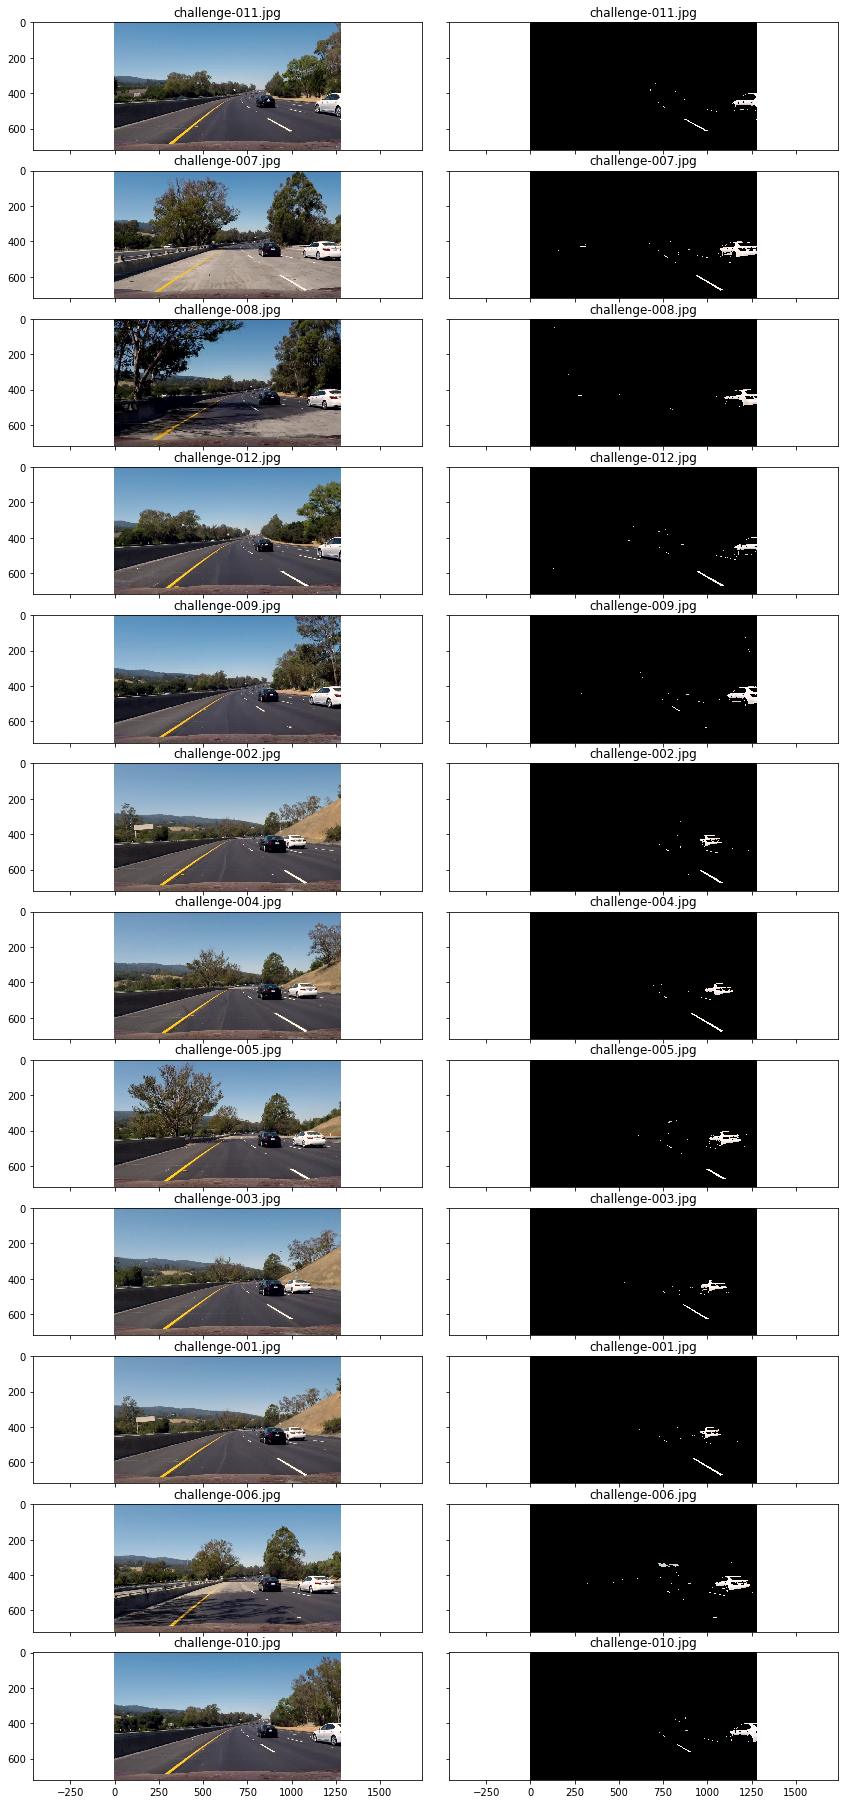

In [31]:
show_transform(input_images, white_selected, title='White Selected')

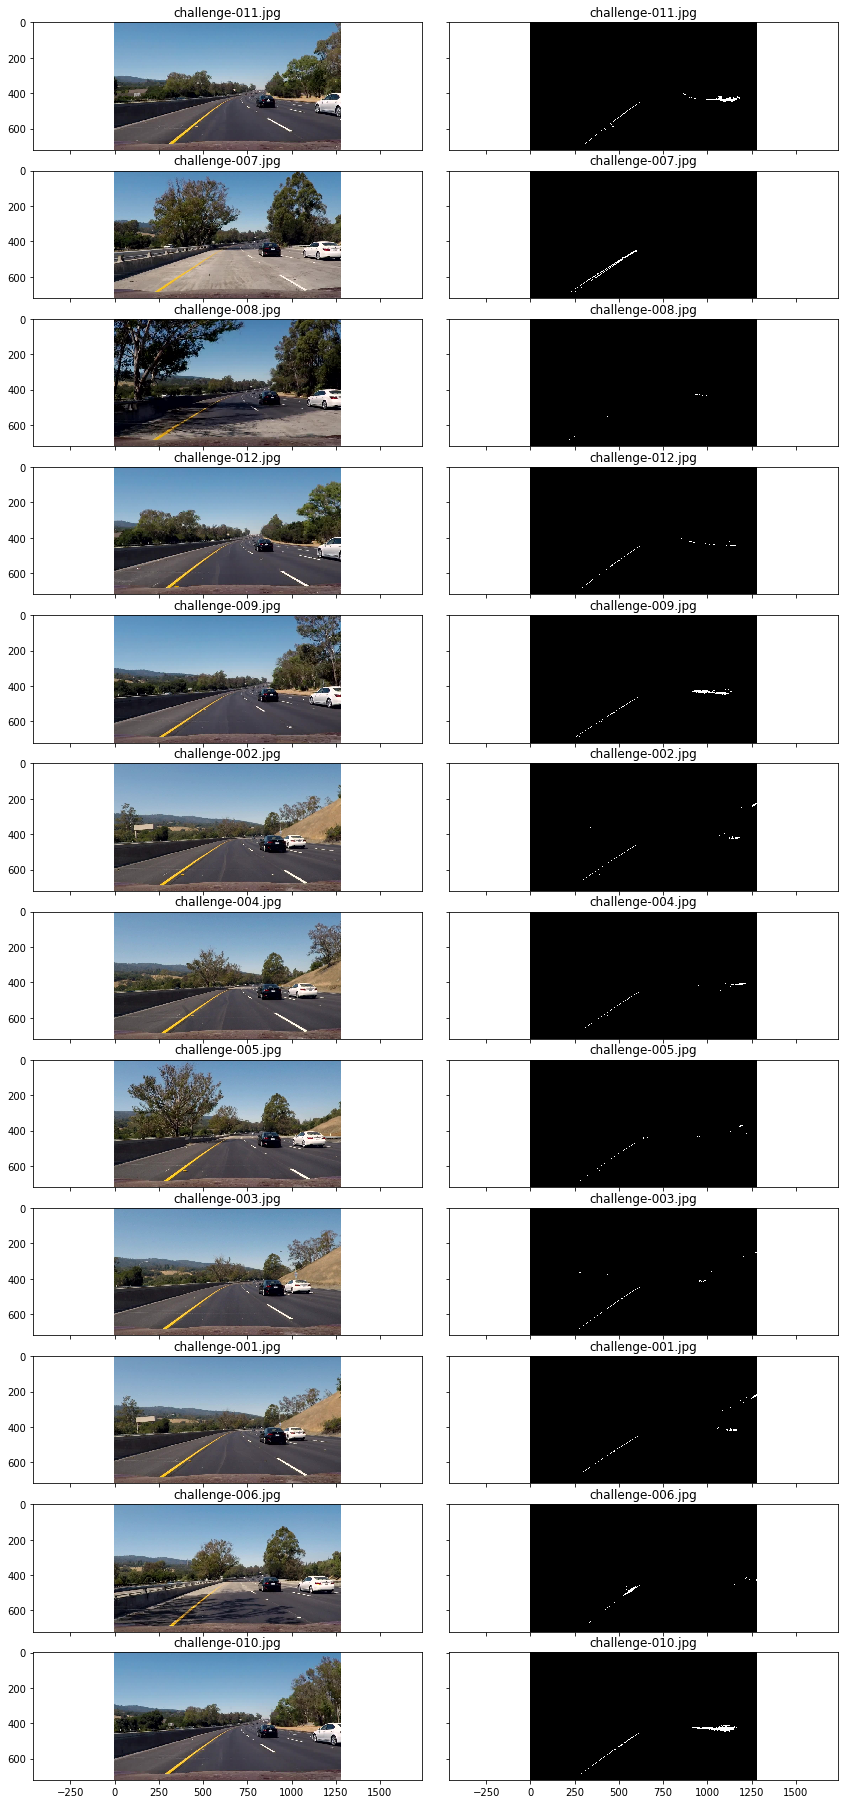

In [32]:
show_transform(input_images, yellow_selected, title='Yellow Selected')

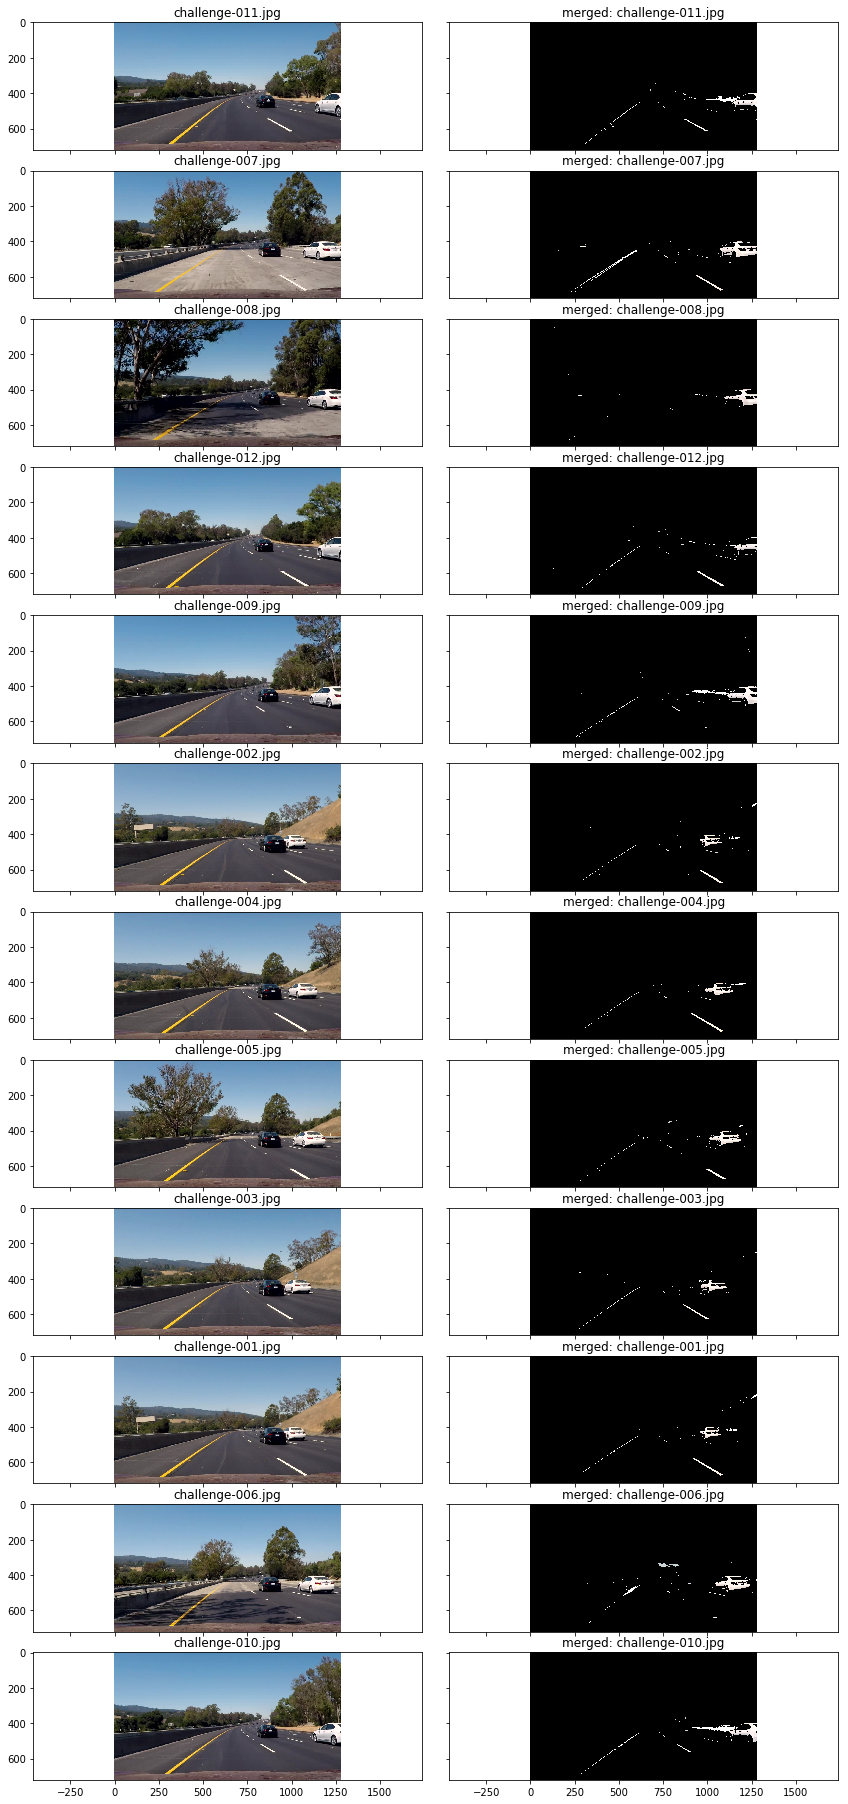

In [33]:
show_transform(input_images, color_selected, title='Color Selected')

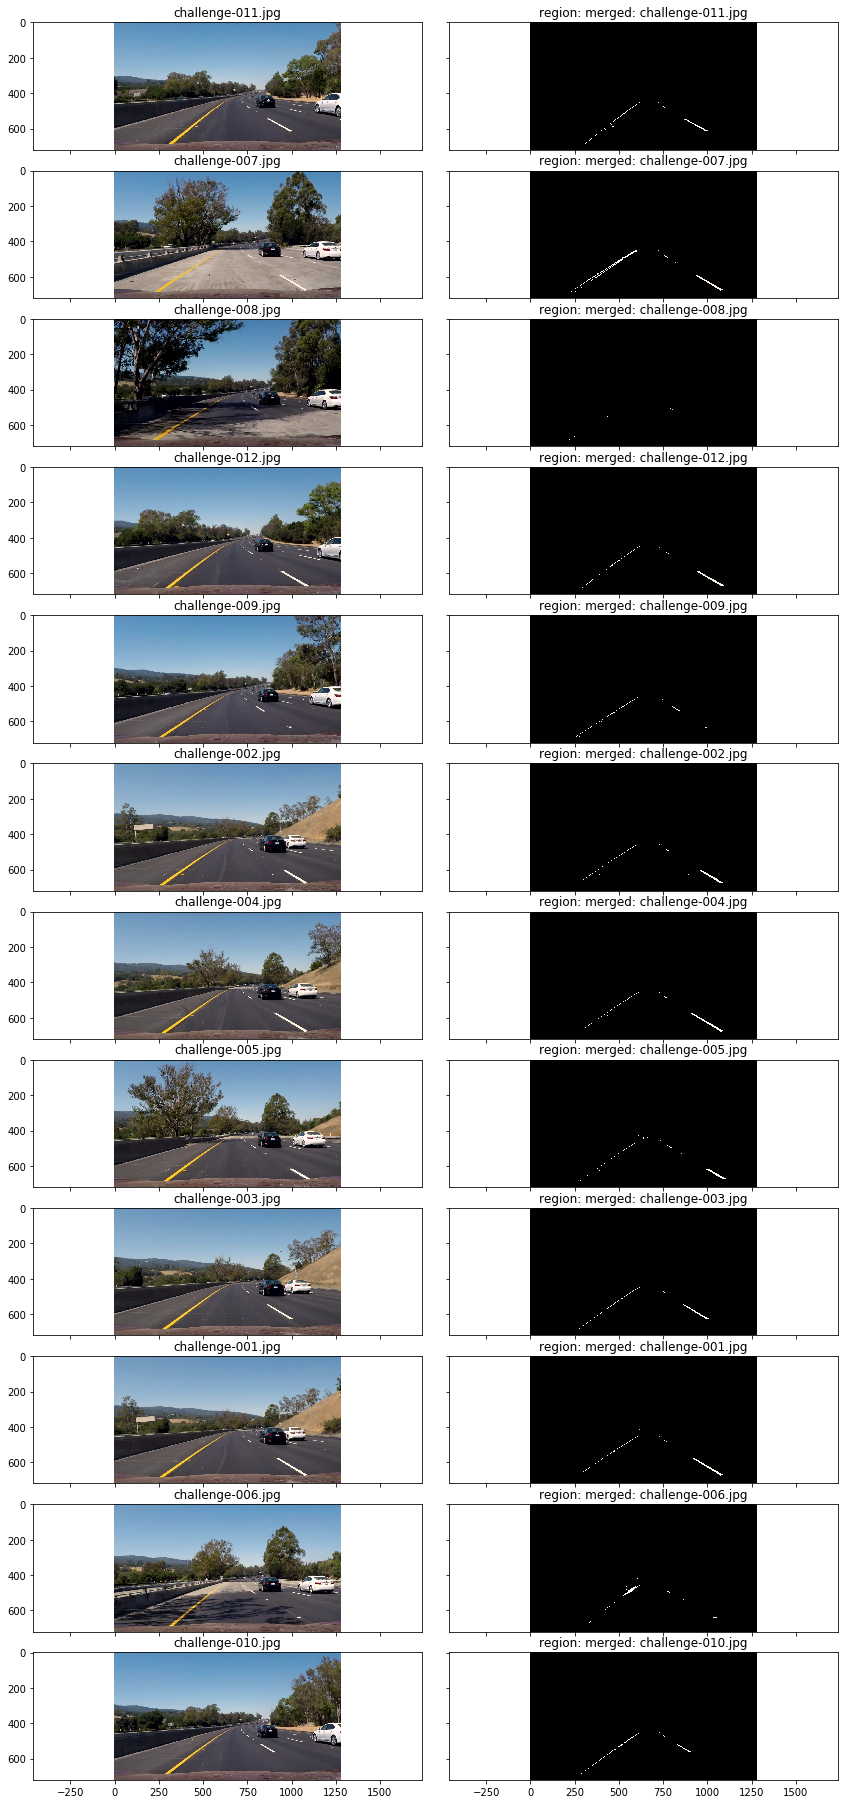

In [39]:
show_transform(input_images, lane_region_selected, title='Lane Region Selected')


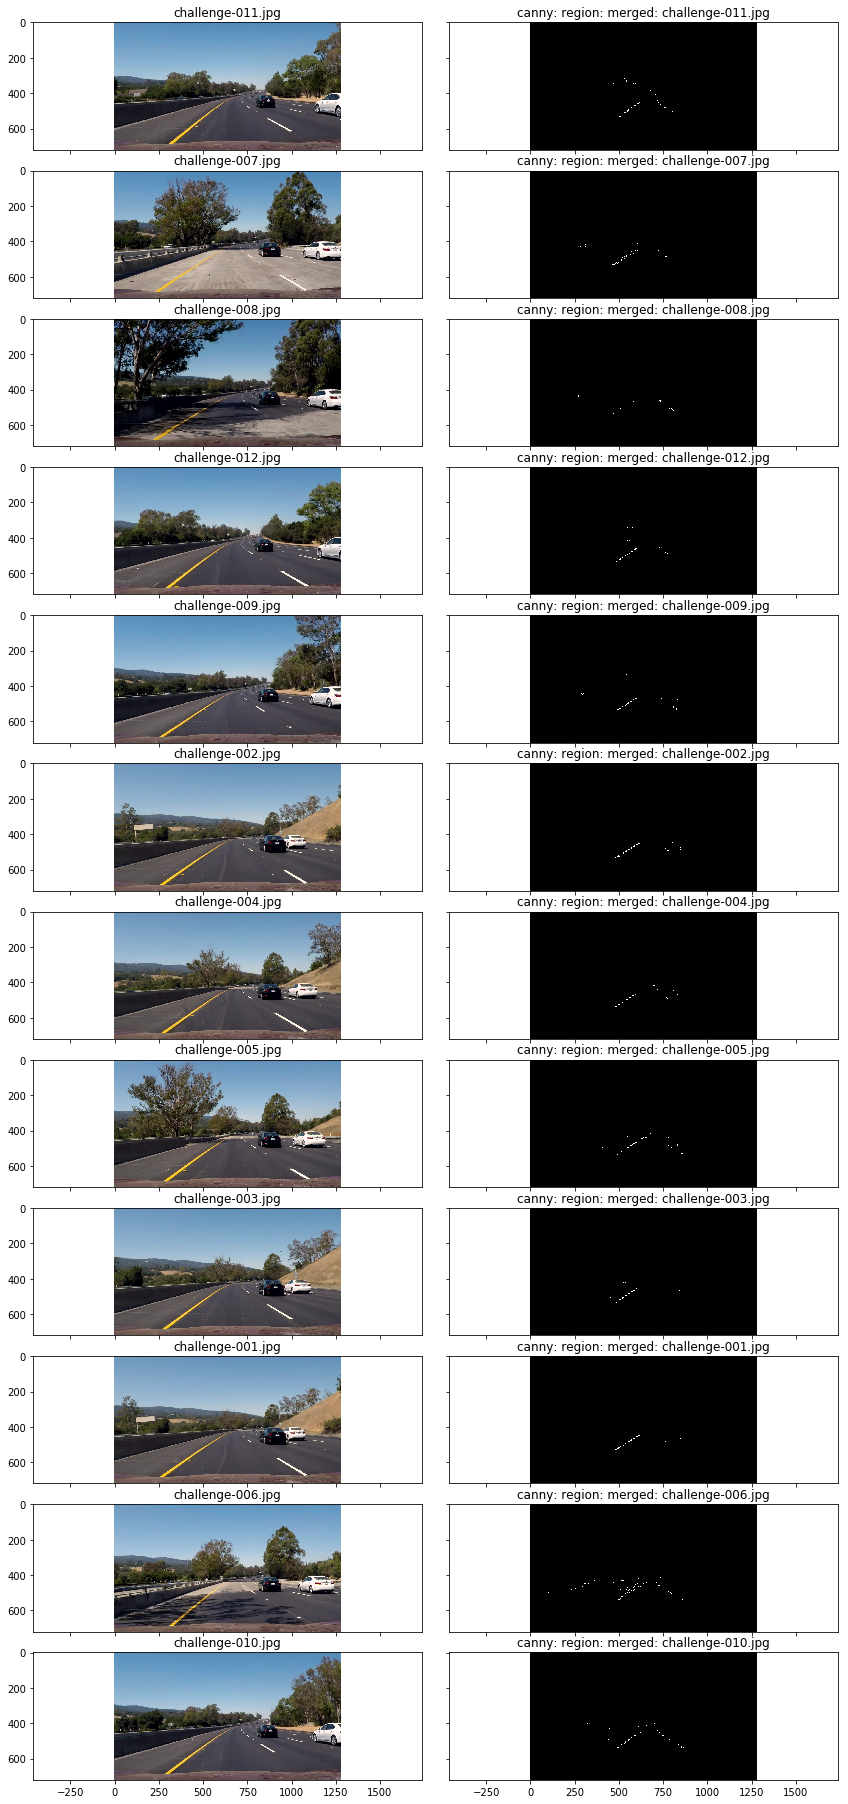

In [35]:
show_transform(input_images, canny_images, after_cmap='Greys_r', title='Canny')

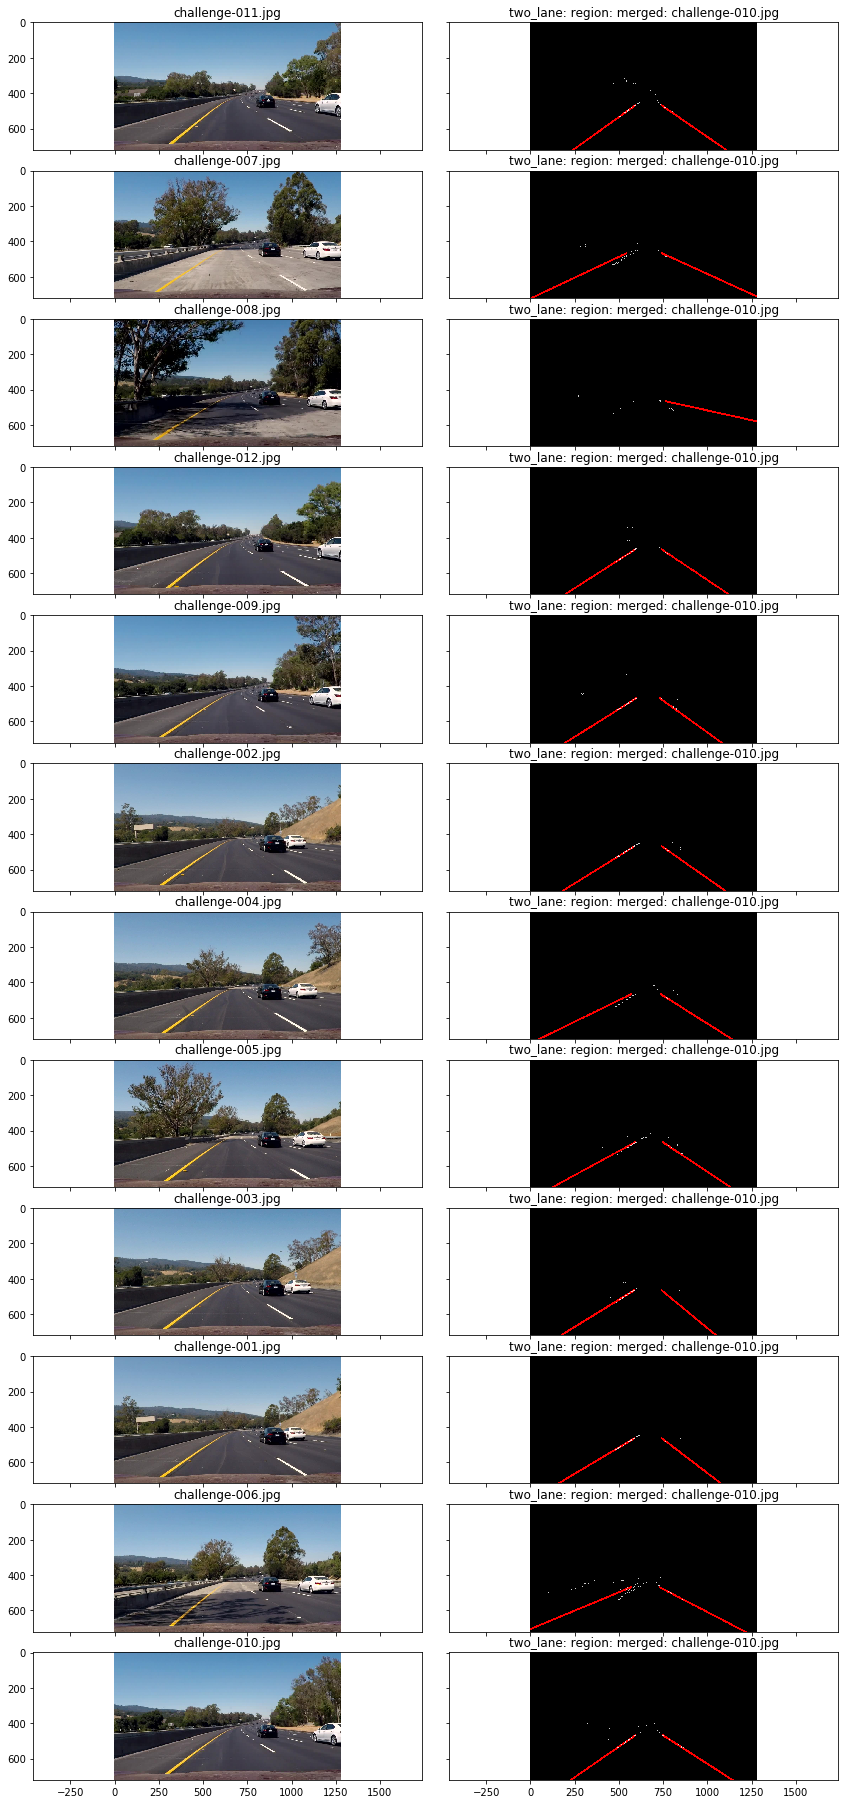

In [36]:
#show_transform(input_images, hough_images, title='Hough')
show_transform(input_images, two_lane_images, title='Two Lanes')

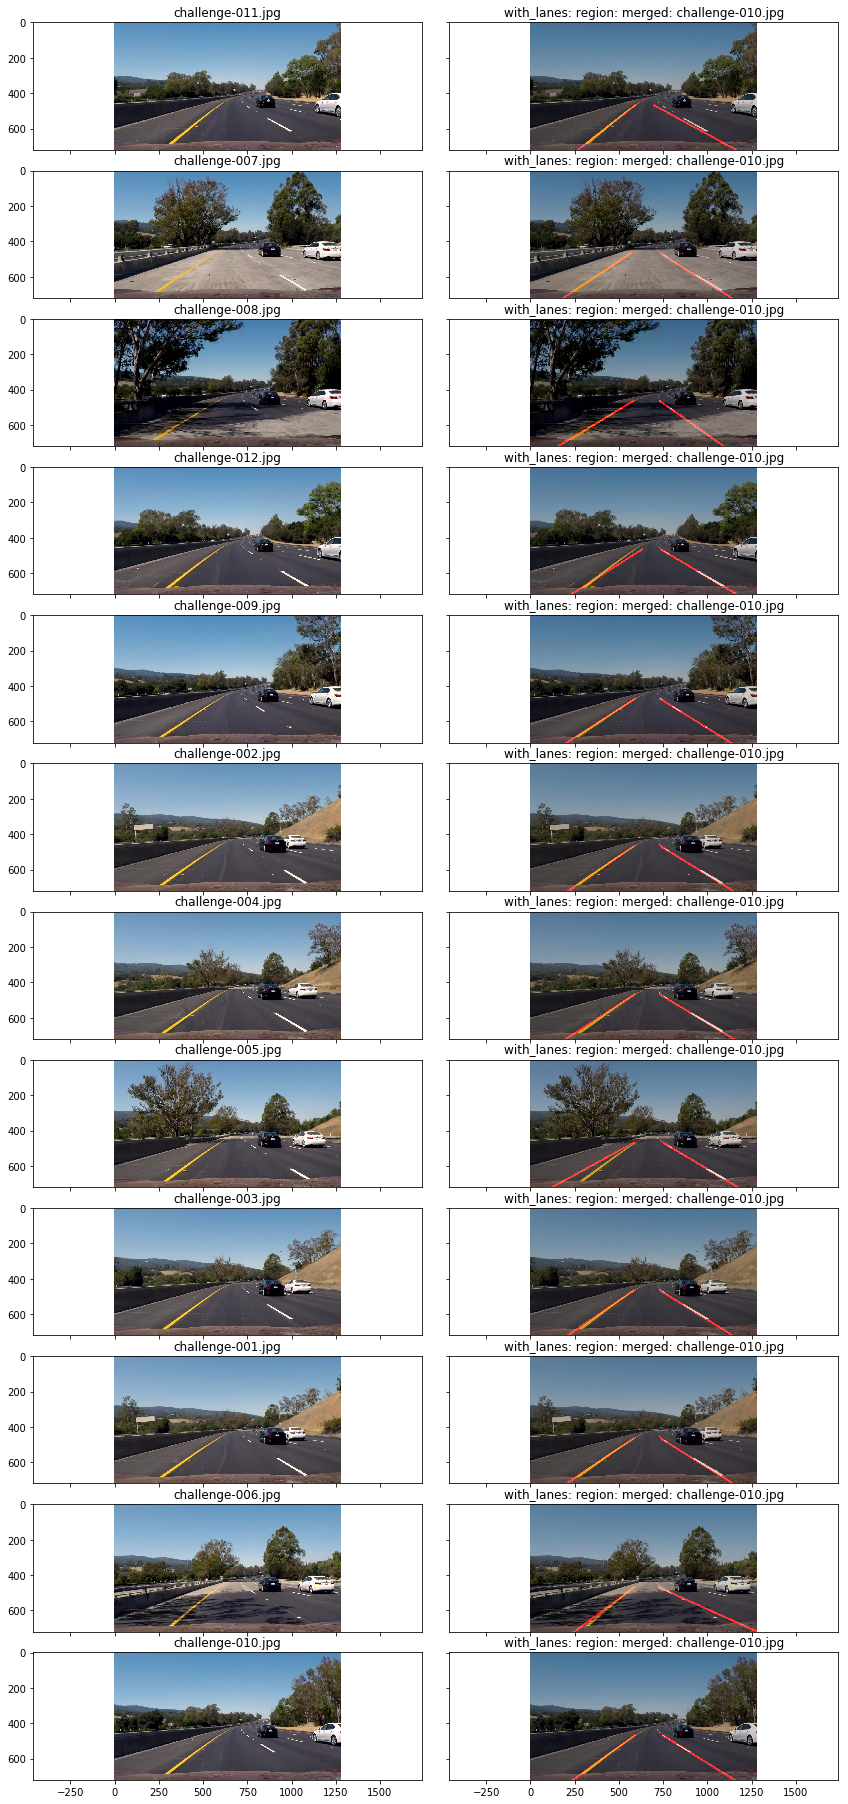

In [40]:
show_transform(input_images, final_images, title='Final')

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [14]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [15]:
def process_image(image):
    white_selected = get_white_selected(image)
    yellow_selected = get_yellow_selected(image)
    merged = get_merged(white_selected, yellow_selected)
    lane_region_selected = get_area_of_interest(merged)
    canny_image = get_canny(lane_region_selected)
    _, _, result = get_lanes(image, canny_image)
    
    return result

-0.791857507166 700.913282771 0.547112871314 50.846794217
-0.660579319663 632.934447118 0.61578483928 12.1480819713
-0.600045960837 611.556670296 0.674796747967 -20.7886178862
-0.720034476615 669.860264649 0.59087629821 24.5931612667
-0.625456704979 634.406111627 0.638522253634 0.200945193056
-0.673461710622 645.393035727 0.600341880342 23.2351596941
-0.643356085083 635.538761831 0.592197105633 25.7449140596
-0.698226614427 661.646636671 0.594993942952 18.6692112271
-0.668039920005 646.716506516 0.606927520878 17.8569337166
-0.67285358834 646.832776343 0.614662892025 12.9518615884
-0.727111001505 671.624196286 0.54827017256 49.1597925357
-0.735298137914 677.139303759 0.600346544585 15.1579885971


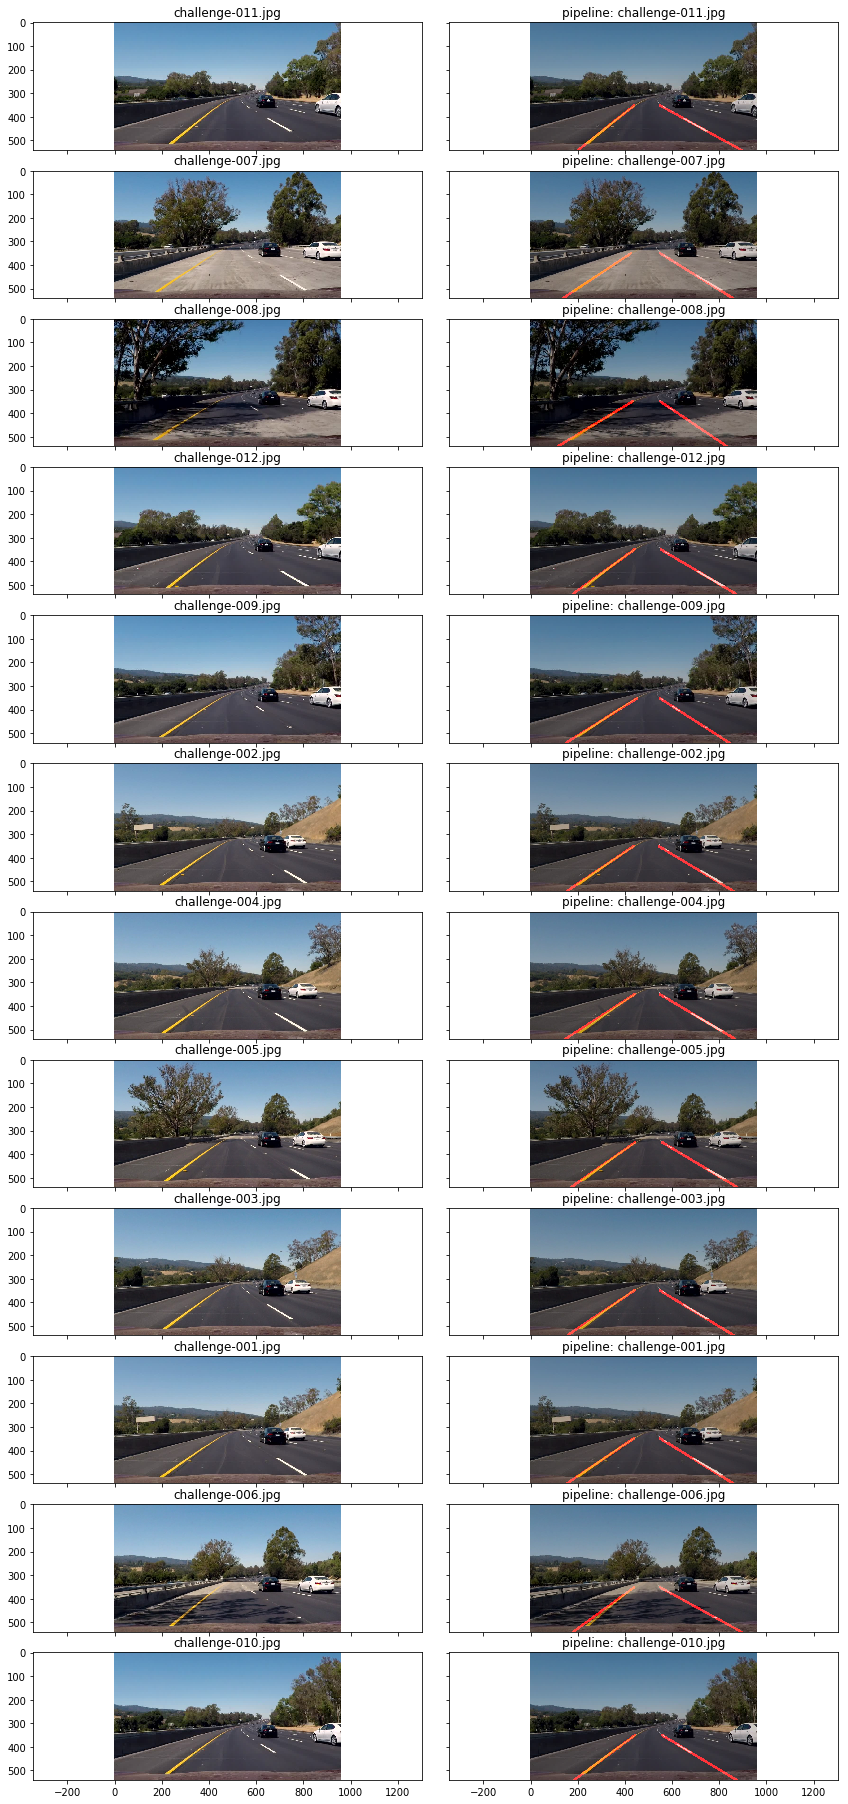

In [16]:
pipeline_images = []
for name, image in input_images:
    pipeline_images.append(('pipeline_'+name, process_image(image)))
show_transform(input_images, pipeline_images, title='Final Through Pipeline')

Let's try the one with the solid white lane on the right first ...

In [17]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

-0.762311416069 663.191222375 0.612576662408 12.417359922
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  0%|          | 1/222 [00:00<00:42,  5.22it/s]

-0.762311416069 663.191222375 0.612576662408 12.417359922
-0.739031629612 655.843512728 0.635593816658 -3.39097414177


  2%|▏         | 4/222 [00:00<00:39,  5.48it/s]

-0.753937993313 662.651484866 0.612264387547 13.4648930754
-0.754300330646 662.73822065 0.611652061481 13.1116882322


  2%|▏         | 5/222 [00:00<00:41,  5.21it/s]

-0.576270159408 627.88044848 0.610108766612 13.9226728841


  3%|▎         | 7/222 [00:01<00:41,  5.13it/s]

-0.711619322546 647.017263825 0.614774546446 10.6308138751
-0.715771258017 647.521924811 0.611806283924 11.7286929115


  4%|▎         | 8/222 [00:01<00:39,  5.35it/s]

-0.732642773364 653.622770546 0.614794258722 9.95840835299
-0.713094771553 645.711121948 0.611210242495 12.6396918802


  5%|▍         | 10/222 [00:01<00:43,  4.89it/s]

-0.708779258902 646.981815323 0.613040777303 13.4943940295


  5%|▍         | 11/222 [00:02<00:45,  4.64it/s]

-0.714447629751 650.659901853 0.609236681584 19.2152452355
-0.711880563332 650.60874494 0.614674222642 17.7026778765


  6%|▋         | 14/222 [00:02<00:39,  5.28it/s]

-0.716377289761 651.388585137 0.632826594636 3.5709834663
-0.722079090737 649.685569225 0.637990238703 1.08473517484


  7%|▋         | 16/222 [00:03<00:37,  5.55it/s]

-0.647620593992 637.723846391 0.633443173033 2.13445869734
-0.611356875016 628.576687789 0.635562732383 -0.702468966926


  8%|▊         | 17/222 [00:03<00:36,  5.68it/s]

-0.555168444345 616.57908448 0.639028562745 -4.02093890649


  8%|▊         | 18/222 [00:03<00:38,  5.36it/s]

-0.693184535688 636.520546066 0.641968197091 -4.04504853711


  9%|▊         | 19/222 [00:03<00:40,  4.98it/s]

-0.690614296232 638.324136496 0.638026022624 -1.45582993209


  9%|▉         | 20/222 [00:03<00:42,  4.80it/s]

-0.686130142969 637.411099249 0.636853952518 0.0645773004758


 10%|▉         | 22/222 [00:04<00:39,  5.09it/s]

-0.713357504979 648.850777295 0.638296978397 0.243751271146
-0.695779859812 643.005169376 0.639428549846 -0.0350102157435


 11%|█         | 24/222 [00:04<00:36,  5.44it/s]

-0.71179532433 648.164881318 0.632935528866 3.82774487027
-0.695812490223 643.167043199 0.641710338648 -1.58591690833


 12%|█▏        | 26/222 [00:04<00:34,  5.70it/s]

-0.70959705342 645.657741574 0.640418676774 -1.83672161448
-0.705898936985 643.467102287 0.637352864829 -0.0406102036065


 13%|█▎        | 28/222 [00:05<00:33,  5.81it/s]

-0.697201149234 644.442506426 0.639189638945 -1.06567408321
-0.59310214057 629.799837564 0.634565253123 0.883634944116


 14%|█▎        | 30/222 [00:05<00:32,  5.82it/s]

-0.525100204525 617.768633609 0.635327329875 1.47954354336
-0.720338451533 651.638841155 0.636168298913 0.0537733326182


 14%|█▍        | 31/222 [00:05<00:35,  5.34it/s]

-0.741266479615 656.6537204 0.63213101678 3.10134666427


 14%|█▍        | 32/222 [00:06<00:37,  5.13it/s]

-0.726525424278 652.10949709 0.638117283297 -1.787749349


 15%|█▍        | 33/222 [00:06<00:38,  4.91it/s]

-0.734791921365 654.691883222 0.635199835219 -0.752476266883


 15%|█▌        | 34/222 [00:06<00:39,  4.77it/s]

-0.721889913338 650.606130423 0.635874073756 -0.784210773152


 16%|█▌        | 35/222 [00:06<00:39,  4.72it/s]

-0.70856986461 646.033817031 0.633554442732 1.60149645331


 16%|█▌        | 36/222 [00:06<00:39,  4.70it/s]

-0.738930355282 658.455822979 0.636017279273 1.67105387292


 17%|█▋        | 38/222 [00:07<00:37,  4.94it/s]

-0.712424740011 649.424329502 0.63521614248 1.67469851153
-0.718255651002 652.009148637 0.63940505031 -1.63534507706


 18%|█▊        | 39/222 [00:07<00:36,  5.06it/s]

-0.710073875701 648.930417288 0.639079916453 -0.697092380656
-0.593175302309 629.617216041 0.628206129651 3.67856848922


 19%|█▉        | 42/222 [00:08<00:32,  5.52it/s]

-0.575608097708 626.958615212 0.634104979748 1.60610774297
-0.750834216936 660.749827234 0.662188481617 -19.0837481606


 19%|█▉        | 43/222 [00:08<00:33,  5.41it/s]

-0.743880332397 657.916541657 0.663576776972 -19.0942593752


 20%|█▉        | 44/222 [00:08<00:36,  4.92it/s]

-0.756631837435 662.164437023 0.65728234862 -14.7365531279


 20%|██        | 45/222 [00:08<00:38,  4.56it/s]

-0.721581205995 647.713646548 0.655650082115 -13.9274530099


 21%|██        | 46/222 [00:09<00:39,  4.42it/s]

-0.738670804618 653.757420272 0.658156124678 -16.1429258027


 22%|██▏       | 48/222 [00:09<00:37,  4.69it/s]

-0.74143222789 654.344042989 0.662800239488 -15.9443565763
-0.720519995679 647.458701629 0.664722860847 -19.5965668366


 22%|██▏       | 49/222 [00:09<00:35,  4.83it/s]

-0.731082658427 651.422149146 0.654560722011 -13.1088596655


 23%|██▎       | 50/222 [00:09<00:38,  4.51it/s]

-0.704009040096 643.358775444 0.65963195084 -16.8456846665


 23%|██▎       | 51/222 [00:10<00:38,  4.46it/s]

-0.722972535755 649.089885155 0.66186152046 -18.2829238418


 23%|██▎       | 52/222 [00:10<00:37,  4.57it/s]

-0.604151791832 630.085019899 0.640877244157 -4.11820229825


 24%|██▍       | 53/222 [00:10<00:37,  4.47it/s]

-0.565219427243 619.870325895 0.660353644152 -15.7963611321


 25%|██▍       | 55/222 [00:10<00:34,  4.90it/s]

-0.685291236686 632.057412292 0.640510537357 -2.38770543687
-0.69924365431 638.378590234 0.649298789777 -7.96132574321


 26%|██▌       | 57/222 [00:11<00:30,  5.45it/s]

-0.710679630119 641.114650048 0.645252161029 -4.8744944376
-0.706964042467 641.670888092 0.655258097163 -9.30972646004


 27%|██▋       | 59/222 [00:11<00:30,  5.37it/s]

-0.691391177136 637.332821177 0.644188490869 -1.22235232655
-0.685856758234 634.970059156 0.652006890891 -8.15914560071


 27%|██▋       | 61/222 [00:12<00:29,  5.54it/s]

-0.694896226848 637.04915668 0.636708427758 2.57741082224
-0.704165230896 639.948950121 0.657053618656 -10.6760068578


 28%|██▊       | 63/222 [00:12<00:27,  5.73it/s]

-0.680470558346 632.060674307 0.658831176338 -10.8377898641
-0.689677491726 637.222710709 0.656986352302 -9.99260295708


 29%|██▉       | 65/222 [00:12<00:27,  5.72it/s]

-0.563234833311 616.492239593 0.65496902991 -8.80534308577
-0.670147706714 628.560951899 0.657886704652 -9.26240530196


 30%|███       | 67/222 [00:13<00:26,  5.87it/s]

-0.66774076439 626.299211742 0.643604517336 -0.542691527545
-0.686378094557 631.648967828 0.658936962297 -11.5808192973


 31%|███       | 69/222 [00:13<00:25,  6.01it/s]

-0.663781570393 623.619373593 0.66305336059 -14.6141489215
-0.68570071109 631.641798634 0.657291132214 -11.4920558584


 32%|███▏      | 71/222 [00:13<00:26,  5.75it/s]

-0.689828682828 633.509089911 0.654775793471 -8.5420840857
-0.674469705484 628.139799093 0.658836865511 -10.8234673245


 33%|███▎      | 73/222 [00:14<00:25,  5.75it/s]

-0.662332961664 622.657736588 0.661529001928 -11.8423598147
-0.676791758632 629.231892953 0.661332534081 -11.5096776444


 33%|███▎      | 74/222 [00:14<00:26,  5.58it/s]

-0.678869656676 629.216499849 0.659296471507 -10.1336485969
-0.663019683905 624.664413313 0.663510623703 -13.2104709951


 35%|███▍      | 77/222 [00:14<00:26,  5.49it/s]

-0.678995376435 628.654687351 0.664145542642 -13.0523921499
-0.574347379269 611.404604455 0.666914842315 -12.605431086


 36%|███▌      | 79/222 [00:15<00:25,  5.56it/s]

-0.648111017714 615.79292014 0.663879151786 -11.3543931402
-0.6615618244 621.463946139 0.665602032466 -10.762865601


 36%|███▋      | 81/222 [00:15<00:23,  5.88it/s]

-0.673457294908 625.42031692 0.667983958704 -13.5484129155
-0.659620719167 620.687008513 0.668128546471 -13.88247767


 37%|███▋      | 82/222 [00:15<00:23,  5.91it/s]

-0.665887237688 622.690036366 0.687430589304 -25.7867783211
-0.661429611133 620.992487234 0.682566375815 -23.4180580379


 38%|███▊      | 85/222 [00:16<00:24,  5.69it/s]

-0.664058415275 621.465314568 0.681611887342 -22.9752986179
-0.659290862707 621.213924714 0.683019168939 -24.4115369983


 39%|███▉      | 87/222 [00:16<00:24,  5.60it/s]

-0.654223135015 618.413635514 0.684564165089 -24.6757632749
-0.663944684061 621.608212316 0.681883564686 -22.7731206348


 40%|████      | 89/222 [00:16<00:22,  5.83it/s]

-0.648775441354 620.714316124 0.683835942288 -23.1055346648
-0.654549304103 621.247694816 0.686155306883 -24.2364460751


 41%|████      | 91/222 [00:17<00:23,  5.64it/s]

-0.661164066045 622.242727812 0.683464409854 -23.2131158104
-0.657756620257 623.215400628 0.687793489089 -25.4024134072


 41%|████▏     | 92/222 [00:17<00:22,  5.69it/s]

-0.649624812657 620.857370699 0.687786193223 -24.5668884927
-0.636814810768 615.901501957 0.688963848699 -25.597496584


 43%|████▎     | 95/222 [00:18<00:23,  5.51it/s]

-0.659756652907 623.619509897 0.684638107731 -23.2693118144
-0.662474869972 624.014093568 0.692462233419 -28.8941713346


 44%|████▎     | 97/222 [00:18<00:21,  5.79it/s]

-0.661535101507 623.135480393 0.688256942871 -27.2273737612
-0.660724657426 623.156527275 0.706431791284 -39.3349697603


 45%|████▍     | 99/222 [00:18<00:21,  5.66it/s]

-0.661941245741 623.253830157 0.687013843048 -27.8657516368
-0.658933994525 621.579708573 0.73129459561 -54.1156990505


 45%|████▌     | 101/222 [00:19<00:20,  5.87it/s]

-0.574686383712 610.55436012 0.701324637768 -38.715020065
-0.646803339217 619.537620678 0.712449144007 -46.7939088062


 46%|████▌     | 102/222 [00:19<00:20,  5.90it/s]

-0.680713995433 632.115612293 0.68846147088 -28.7105494975
-0.640873795267 618.298985729 0.688488735938 -28.6452171098


 47%|████▋     | 105/222 [00:19<00:20,  5.70it/s]

-0.647562218772 623.44655791 0.687943872395 -27.8853095063
-0.654144327369 623.63318168 0.687335321692 -28.4568786412


 48%|████▊     | 107/222 [00:20<00:21,  5.47it/s]

-0.692011461779 637.983649367 0.686947029171 -29.0766858631
-0.678664506207 632.60695679 0.68936967646 -31.0170335038


 49%|████▉     | 109/222 [00:20<00:19,  5.72it/s]

-0.649825531611 622.042028329 0.682843405399 -28.1022810828
-0.689166713581 636.433985082 0.68228052911 -27.4018429999


 50%|████▉     | 110/222 [00:20<00:20,  5.36it/s]

-0.679722254972 634.335145218 0.688310809358 -32.2124256019


 50%|█████     | 111/222 [00:20<00:23,  4.77it/s]

-0.686554690917 635.679970124 0.686831767615 -29.0963648207


 50%|█████     | 112/222 [00:21<00:24,  4.48it/s]

-0.69223117977 639.091715564 0.695395859695 -37.473896549


 51%|█████     | 113/222 [00:21<00:23,  4.55it/s]

-0.679269085195 633.238410427 0.68602805448 -29.7998123837


 51%|█████▏    | 114/222 [00:21<00:23,  4.66it/s]

-0.675489572441 631.22919063 0.683253284149 -28.8139175899
-0.657751595484 623.293215513 0.69365361787 -37.9264820876


 52%|█████▏    | 116/222 [00:22<00:21,  4.85it/s]

-0.702786514544 639.228403741 0.687817509728 -33.092785116


 53%|█████▎    | 118/222 [00:22<00:21,  4.82it/s]

-0.680368247182 632.081988438 0.663158837969 -15.4912516474
-0.664135338346 626.211992481 0.662968688377 -16.506849826


 54%|█████▍    | 120/222 [00:22<00:19,  5.22it/s]

-0.666152292514 626.815726072 0.661531467131 -14.4218122826
-0.678585985116 631.813051523 0.664320900319 -16.7716104721


 55%|█████▍    | 122/222 [00:23<00:18,  5.42it/s]

-0.687898019475 637.130168426 0.658956196698 -14.2238992555
-0.687420135514 636.696893958 0.644709747402 -5.38732203238


 55%|█████▌    | 123/222 [00:23<00:18,  5.25it/s]

-0.600746001275 624.697034832 0.635004898175 0.137358917678


 56%|█████▌    | 124/222 [00:23<00:19,  5.04it/s]

-0.589389802937 619.577766439 0.639439696834 -2.46853333889


 56%|█████▋    | 125/222 [00:23<00:20,  4.72it/s]

-0.601074900794 623.519767645 0.63287725843 0.548556845207


 57%|█████▋    | 126/222 [00:24<00:20,  4.64it/s]

-0.700054484338 643.323105977 0.639764098068 -2.40121835389


 57%|█████▋    | 127/222 [00:24<00:21,  4.51it/s]

-0.685674525557 637.998952861 0.638176510959 -1.45193338157


 58%|█████▊    | 128/222 [00:24<00:21,  4.31it/s]

-0.690758459747 641.291147415 0.638965639665 -2.79460591768


 58%|█████▊    | 129/222 [00:24<00:21,  4.40it/s]

-0.693146096097 641.234847464 0.638219862995 -3.01434627361
-0.686048482716 640.216445356 0.629750931811 1.96814698846


 59%|█████▉    | 131/222 [00:25<00:19,  4.68it/s]

-0.719199395582 654.263236821 0.636942225859 -2.7922543816


 60%|█████▉    | 133/222 [00:25<00:17,  5.08it/s]

-0.691199672165 642.533982174 0.634973134606 -0.286168204246
-0.708520143696 648.174082778 0.638534587049 -3.66925938964


 60%|██████    | 134/222 [00:25<00:16,  5.36it/s]

-0.709263910897 647.552913376 0.63850425292 -2.89650929808
-0.695776678139 642.405681909 0.636908942745 -3.5820572183


 61%|██████▏   | 136/222 [00:26<00:15,  5.40it/s]

-0.590674071556 627.217623787 0.639577032877 -5.91866958562


 62%|██████▏   | 138/222 [00:26<00:16,  5.24it/s]

-0.709996439261 644.992688139 0.63625275704 -4.72763797064
-0.699887087824 641.85152184 0.635375707017 -4.51905921613


 63%|██████▎   | 139/222 [00:26<00:17,  4.79it/s]

-0.713573712313 648.532312117 0.632488484952 -1.85946615476


 63%|██████▎   | 140/222 [00:26<00:17,  4.66it/s]

-0.734646012996 657.564185888 0.638497923358 -5.67353814098


 64%|██████▎   | 141/222 [00:27<00:17,  4.71it/s]

-0.715894356415 652.500417857 0.633245284756 -0.308759228892


 64%|██████▍   | 142/222 [00:27<00:17,  4.62it/s]

-0.725611129995 656.00260701 0.637821990286 -2.08138295993


 64%|██████▍   | 143/222 [00:27<00:17,  4.41it/s]

-0.715022359316 653.978093583 0.633648288897 0.127880092561


 65%|██████▌   | 145/222 [00:28<00:16,  4.71it/s]

-0.709998347317 651.149570302 0.639095935127 -3.39387754674
-0.742165827468 662.470890908 0.639166690922 -2.99286470679


 66%|██████▌   | 147/222 [00:28<00:14,  5.11it/s]

-0.721961160761 655.055484981 0.632783963042 -2.09884554519
-0.649634039608 644.624006395 0.634032299168 -5.37128547236


 67%|██████▋   | 148/222 [00:28<00:14,  5.28it/s]

-0.726055857744 655.391542259 0.632332179137 -3.36462501006


 67%|██████▋   | 149/222 [00:28<00:14,  5.04it/s]

-0.586273122146 633.252005365 0.642728366563 -9.31636496689


 68%|██████▊   | 150/222 [00:29<00:14,  4.80it/s]

-0.725983411349 657.070756344 0.607291946871 12.9977512497


 68%|██████▊   | 151/222 [00:29<00:15,  4.58it/s]

-0.739333934029 661.308897539 0.608801352037 11.5851494885


 69%|██████▉   | 153/222 [00:29<00:14,  4.70it/s]

-0.734691310887 661.157221063 0.643696587541 -11.689978461
-0.738392751952 662.133808615 0.630494641175 -1.85072824983


 69%|██████▉   | 154/222 [00:29<00:13,  4.99it/s]

-0.596502466694 638.294209454 0.63491866308 -5.99658239793
-0.720709870703 655.74757679 0.639068140236 -9.27697052861


 71%|███████   | 157/222 [00:30<00:11,  5.52it/s]

-0.761655437555 668.776144798 0.632118824397 -4.74389246452
-0.742641999602 662.257710641 0.610146116942 10.7256570099


 71%|███████   | 158/222 [00:30<00:12,  5.20it/s]

-0.777201461721 673.761816274 0.633409511111 -6.39061344774


 72%|███████▏  | 159/222 [00:30<00:13,  4.57it/s]

-0.737956188234 660.348500227 0.616713683949 5.28940999725


 72%|███████▏  | 160/222 [00:31<00:14,  4.30it/s]

-0.734831644111 659.917502628 0.616676852262 4.44434001752


 73%|███████▎  | 161/222 [00:31<00:14,  4.25it/s]

-0.585968856776 637.39546068 0.614727013682 4.64699406696


 73%|███████▎  | 162/222 [00:31<00:14,  4.01it/s]

-0.772186773967 678.867478681 0.611458884444 6.86635550888


 73%|███████▎  | 163/222 [00:31<00:14,  3.94it/s]

-0.746847500542 668.39865864 0.612806715146 4.97442811445


 74%|███████▍  | 164/222 [00:32<00:14,  3.99it/s]

-0.760869828753 675.019191089 0.595762714302 16.4289701378


 74%|███████▍  | 165/222 [00:32<00:13,  4.19it/s]

-0.739880157539 666.642475619 0.587798638941 24.1972403373


 75%|███████▍  | 166/222 [00:32<00:13,  4.19it/s]

-0.613318866133 649.741570595 0.588592737573 22.6926825998


 75%|███████▌  | 167/222 [00:32<00:13,  4.18it/s]

-0.756345009914 674.600016523 0.588990358252 24.95168998


 76%|███████▌  | 168/222 [00:33<00:13,  4.15it/s]

-0.771360955111 680.050075072 0.588732072938 23.1547970918


 76%|███████▌  | 169/222 [00:33<00:12,  4.13it/s]

-0.767339838136 678.299372211 0.590076831593 22.6208203171


 77%|███████▋  | 170/222 [00:33<00:12,  4.17it/s]

-0.767962904238 678.477299254 0.590922418791 22.7446993052


 77%|███████▋  | 171/222 [00:33<00:12,  4.11it/s]

-0.774094255045 682.172417207 0.589663911713 23.0862440867


 77%|███████▋  | 172/222 [00:34<00:12,  4.10it/s]

-0.784743348573 684.632519805 0.586513627615 25.0287716521


 78%|███████▊  | 173/222 [00:34<00:12,  4.04it/s]

-0.673568132353 661.148881629 0.585711163937 24.7390517244


 78%|███████▊  | 174/222 [00:34<00:11,  4.06it/s]

-0.750441032955 671.191384843 0.58839155483 23.3805369232


 79%|███████▉  | 176/222 [00:34<00:10,  4.58it/s]

-0.786645468998 684.514281929 0.586218649864 24.1098604899
-0.752672919669 673.091681032 0.587870939436 23.8546827725


 80%|███████▉  | 177/222 [00:35<00:09,  4.74it/s]

-0.794176751091 689.012241348 0.589082378568 23.3527138177


 80%|████████  | 178/222 [00:35<00:09,  4.47it/s]

-0.768092529178 679.830766985 0.582421072317 26.161591178


 81%|████████  | 179/222 [00:35<00:09,  4.35it/s]

-0.788299918654 687.110662811 0.586593390342 23.4676408997


 81%|████████  | 180/222 [00:35<00:09,  4.31it/s]

-0.79804909222 690.937342682 0.59053200859 19.8844473843


 82%|████████▏ | 181/222 [00:36<00:09,  4.28it/s]

-0.815276366978 695.9929555 0.587396784867 22.0535117338


 82%|████████▏ | 182/222 [00:36<00:09,  4.15it/s]

-0.799899664075 692.188822151 0.590035259161 21.381127388


 82%|████████▏ | 183/222 [00:36<00:09,  4.07it/s]

-0.79927181413 691.082108656 0.584480834589 22.1933145073
-0.801604267505 692.546736007 0.583573927983 23.9432562423


 83%|████████▎ | 185/222 [00:37<00:08,  4.38it/s]

-0.670121094555 666.479373457 0.5959128046 15.3655403568


 84%|████████▍ | 186/222 [00:37<00:07,  4.51it/s]

-0.791060869043 684.993823682 0.58607807549 22.0962553102


 84%|████████▍ | 187/222 [00:37<00:07,  4.50it/s]

-0.772305764411 679.092606516 0.589015162928 21.323373551
-0.802610459864 689.289819574 0.588720385696 19.4694997408


 86%|████████▌ | 190/222 [00:38<00:06,  5.29it/s]

-0.780576903417 679.374019593 0.585744715159 18.7259323362
-0.795373359468 682.515179121 0.584699361178 16.5714144133


 86%|████████▋ | 192/222 [00:38<00:05,  5.31it/s]

-0.802915720718 687.402463397 0.558553236215 34.9848598295
-0.776704901825 679.781679123 0.562780376445 33.5170907611


 87%|████████▋ | 194/222 [00:38<00:05,  5.48it/s]

-0.806445466735 692.087345888 0.5884139501 19.1241375061
-0.794972296461 689.189913854 0.593623158796 18.9216079733


 88%|████████▊ | 196/222 [00:39<00:04,  5.60it/s]

-0.625688258388 655.62840546 0.590574523289 22.1378926239
-0.646675646569 658.685273595 0.592772638175 22.1503881469


 89%|████████▊ | 197/222 [00:39<00:04,  5.63it/s]

-0.669245453389 665.460878127 0.590682808717 20.8243486683
-0.755444798068 671.972251913 0.590446154235 20.6474352703


 90%|████████▉ | 199/222 [00:39<00:04,  5.23it/s]

-0.773622297309 680.016833229 0.591059626068 18.0628980464


 90%|█████████ | 200/222 [00:39<00:04,  4.73it/s]

-0.796785041977 688.928028159 0.591152721857 19.7331171059


 91%|█████████ | 201/222 [00:40<00:04,  4.57it/s]

-0.804537133677 691.117058028 0.588513841327 21.1202598916


 91%|█████████ | 202/222 [00:40<00:04,  4.39it/s]

-0.810185445879 692.686368691 0.597390741434 14.0828611456


 92%|█████████▏| 204/222 [00:40<00:03,  4.76it/s]

-0.781418398205 683.187657302 0.558469816275 40.8992337543
-0.830819177913 701.050789354 0.609508754477 3.51074197568


 93%|█████████▎| 206/222 [00:41<00:03,  5.29it/s]

-0.78743362667 685.625867175 0.56553256403 32.7157852449
-0.792649149385 685.839742922 0.558662073469 37.7488175283


 93%|█████████▎| 207/222 [00:41<00:02,  5.12it/s]

-0.798381908984 688.232786107 0.569074117599 31.1205636716


 94%|█████████▎| 208/222 [00:41<00:02,  4.82it/s]

-0.679637008688 667.237418455 0.566454772345 31.4342744457


 94%|█████████▍| 209/222 [00:41<00:02,  4.63it/s]

-0.670448482139 663.490824142 0.563553480948 32.701591535


 95%|█████████▍| 210/222 [00:42<00:02,  4.57it/s]

-0.794866934567 685.177079384 0.566580561508 32.2134159869


 95%|█████████▌| 211/222 [00:42<00:02,  4.61it/s]

-0.820461902529 696.647783136 0.565450319527 32.053359793
-0.788776337618 685.75453391 0.564456815284 34.2462974657


 96%|█████████▌| 213/222 [00:42<00:01,  4.83it/s]

-0.802559005797 690.01324585 0.567780601731 33.2085969078
-0.79883823322 689.614489465 0.562417143351 36.8398703101


 97%|█████████▋| 215/222 [00:43<00:01,  4.55it/s]

-0.824871354792 697.929423332 0.567826686171 34.3478945443


 97%|█████████▋| 216/222 [00:43<00:01,  4.50it/s]

-0.799094438139 689.460868615 0.565954215534 36.2021243309
-0.817318001896 696.534083029 0.567728797658 35.6857612747


 98%|█████████▊| 218/222 [00:43<00:00,  4.68it/s]

-0.800610212209 688.831278847 0.56385455336 37.139952846


 99%|█████████▉| 220/222 [00:44<00:00,  4.79it/s]

-0.680465291932 663.00122512 0.568168594166 35.2613160668
-0.695290594794 667.975149743 0.566737222747 35.7028134926


100%|█████████▉| 221/222 [00:44<00:00,  4.77it/s]

-0.651064994285 657.097650699 0.565231490087 36.3270822218


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 46.7 s, sys: 598 ms, total: 47.3 s
Wall time: 46.8 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [19]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

-0.613602149522 608.673296584 0.679740172397 -24.1764986507
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  0%|          | 0/682 [00:00<?, ?it/s]

-0.613602149522 608.673296584 0.679740172397 -24.1764986507


  0%|          | 2/682 [00:00<01:55,  5.91it/s]

-0.609845713217 608.416875643 0.682482718279 -27.8141904648


  0%|          | 3/682 [00:00<01:57,  5.79it/s]

-0.605008951461 608.512976682 0.696456016043 -38.7156277068


  1%|          | 4/682 [00:00<01:55,  5.88it/s]

-0.635679156729 616.629018684 0.678996785294 -24.9439669059


  1%|          | 5/682 [00:00<01:54,  5.92it/s]

-0.622274909853 616.982012859 0.665625254064 -14.9597305003


  1%|          | 6/682 [00:01<01:53,  5.94it/s]

-0.641351398828 621.574892255 0.657899090157 -13.1978494624


  1%|          | 7/682 [00:01<01:56,  5.79it/s]

-0.633408785292 620.23991008 0.667971584858 -19.4019021316


  1%|          | 8/682 [00:01<01:58,  5.67it/s]

-0.635343020709 620.23574167 0.661699199199 -16.7148335836
-0.632668139042 619.24933521 0.662041604438 -17.4715627834


  1%|▏         | 10/682 [00:01<01:58,  5.69it/s]

-0.66762695435 627.244975017 0.661456813541 -18.0580032913


  2%|▏         | 11/682 [00:01<01:54,  5.84it/s]

-0.646350065615 623.642762522 0.660771814646 -17.5160734115


  2%|▏         | 12/682 [00:02<01:57,  5.72it/s]

-0.661635700064 626.389911021 0.659653253691 -17.3496288413


  2%|▏         | 13/682 [00:02<01:54,  5.87it/s]

-0.677471286725 632.060518042 0.648695065244 -10.3653625222


  2%|▏         | 14/682 [00:02<01:55,  5.78it/s]

-0.63728517578 626.293905622 0.654199016134 -13.607458304


  2%|▏         | 15/682 [00:02<01:56,  5.72it/s]

-0.675175234369 632.946987183 0.636065731664 -2.32565469539
-0.685454986731 641.01212917 0.636860610019 -2.6431418917


  2%|▏         | 17/682 [00:02<02:03,  5.39it/s]

-0.712366624855 642.082398909 0.633136099428 -1.63158617633


  3%|▎         | 19/682 [00:03<02:08,  5.14it/s]

-0.686012098864 637.857915832 0.521640862632 94.7352618106
-0.69291552082 639.68205442 0.648156741907 -10.1607328482


  3%|▎         | 21/682 [00:03<02:04,  5.31it/s]

-0.685049119081 637.556434082 0.6481917558 -10.7864508917
-0.695271394354 639.998398897 0.644050714635 -9.29745630959


  3%|▎         | 22/682 [00:03<02:02,  5.41it/s]

-0.685012838454 636.015568151 0.638352936422 -6.02507769832
-0.695689306908 638.851335997 0.621646676845 4.32140564874


  4%|▎         | 24/682 [00:04<02:02,  5.35it/s]

-0.687552404712 635.33843805 0.63488175598 -4.17856561393
-0.682414588877 635.376511466 0.619046582201 7.33655759953


  4%|▍         | 27/682 [00:04<01:53,  5.75it/s]

-0.688525176034 640.054641636 0.624618070384 3.80170690889
-0.715286704288 652.511803833 0.652135893776 -14.4920700381


  4%|▍         | 29/682 [00:05<01:48,  6.03it/s]

-0.693164241266 642.254683121 0.63159726938 -3.10882467368
-0.696498575045 646.086113754 0.619121687911 5.08622335744


  5%|▍         | 31/682 [00:05<01:51,  5.83it/s]

-0.698215330364 644.433728514 0.609050810608 8.55773365903
-0.706369535336 645.774998625 0.640763841108 -10.1827088173


  5%|▍         | 33/682 [00:05<01:54,  5.66it/s]

-0.697286179617 645.231060065 0.616776303481 3.72491636919
-0.710000997281 646.593130327 0.629344030875 -5.11522470885


  5%|▌         | 35/682 [00:06<01:55,  5.62it/s]

-0.716518764271 649.915916613 0.634155219461 -6.48147206837
-0.744563735344 655.300897236 0.640791568376 -11.2571909786


  5%|▌         | 36/682 [00:06<01:55,  5.57it/s]

-0.742025005133 656.172548805 0.620691868667 0.698390603815


  6%|▌         | 38/682 [00:06<02:00,  5.36it/s]

-0.739654493764 656.726558225 0.609352267784 8.30025990569
-0.734036117898 653.943755569 0.609728103753 7.32511802016


  6%|▌         | 40/682 [00:07<01:57,  5.48it/s]

-0.737990019024 654.724304986 0.611459423906 5.22097922289
-0.722707494074 651.140328945 0.615758274107 2.52466896822


  6%|▌         | 42/682 [00:07<01:51,  5.75it/s]

-0.742343720725 654.767700358 0.597942754115 15.6551815046
-0.744128773535 656.491958441 0.609534710046 7.66352685239


  6%|▋         | 43/682 [00:07<02:05,  5.08it/s]

-0.75164007951 655.835953376 0.487283125898 113.63047518


  6%|▋         | 44/682 [00:08<02:16,  4.69it/s]

-0.738617518357 651.305625906 0.637133303342 -8.59988260735


  7%|▋         | 45/682 [00:08<02:14,  4.74it/s]

-0.733692681056 651.618869814 0.636701981876 -6.92925088507
-0.710821603719 645.906851488 0.629794784531 -3.12751186546


  7%|▋         | 47/682 [00:08<02:12,  4.81it/s]

-0.758814531701 657.457987277 0.608928565029 10.0923000729


  7%|▋         | 48/682 [00:08<02:13,  4.76it/s]

-0.737662013017 653.674788354 0.615094526368 6.92063913736
-0.751775334373 655.719866873 0.63633126239 -5.73846654285


  7%|▋         | 50/682 [00:09<02:11,  4.82it/s]

-0.741580650884 653.423571519 0.607449319897 9.86531646431
-0.735942677811 653.559874923 0.610247614235 8.86561866508


  8%|▊         | 52/682 [00:09<02:18,  4.56it/s]

-0.725017034866 649.768254335 0.60797955168 10.1848256182


  8%|▊         | 53/682 [00:09<02:21,  4.43it/s]

-0.717947017776 647.797035818 0.609459487131 9.3516704961


  8%|▊         | 54/682 [00:10<02:19,  4.50it/s]

-0.751987645868 656.186836129 0.611933903853 8.91745197847
-0.717606214892 647.446585854 0.609269863555 11.1550331303


  8%|▊         | 56/682 [00:10<02:19,  4.50it/s]

-0.66428770027 638.397794305 0.607336020678 13.162723997
-0.735295933705 653.390991745 0.630295407637 -0.809191176471


  9%|▊         | 59/682 [00:11<02:02,  5.08it/s]

-0.749126985506 655.865092116 0.615887802384 8.58474871138
-0.701151124793 643.803776393 0.593898207909 21.8309541375


  9%|▉         | 61/682 [00:11<01:56,  5.33it/s]

-0.717125680418 646.833349671 0.647728059454 -9.35260549326
-0.711480605212 644.988942966 0.638216758684 -4.46379293566


  9%|▉         | 62/682 [00:11<02:03,  5.02it/s]

-0.738884810534 647.95074559 0.628351661579 1.39259858208


  9%|▉         | 63/682 [00:11<02:07,  4.85it/s]

-0.71181379713 641.070025952 0.628219241491 1.01364475372


  9%|▉         | 64/682 [00:12<02:13,  4.63it/s]

-0.713678260997 642.780447028 0.608077640104 13.2919293654


 10%|▉         | 65/682 [00:12<02:17,  4.48it/s]

-0.712800650225 641.85221389 0.611532355768 12.6467775588


 10%|▉         | 66/682 [00:12<02:20,  4.38it/s]

-0.736387521682 647.296264258 0.614141726552 11.8238376602
-0.721505133815 646.052558309 0.608624576058 16.4348303749


 10%|▉         | 68/682 [00:13<02:08,  4.78it/s]

-0.706732104859 642.609941179 0.606955526735 14.7346011093
-0.726051996765 647.332142009 0.610079255935 14.65928163


 10%|█         | 71/682 [00:13<01:57,  5.20it/s]

-0.714902565131 644.38904357 0.634218559219 -0.949877899878
-0.681195501372 635.13481648 0.648227030171 -9.01929372068


 11%|█         | 73/682 [00:13<01:52,  5.40it/s]

-0.691557534453 639.666233103 0.611384629917 14.2433811101
-0.678286789432 636.529724638 0.635093386467 -1.43607857344


 11%|█         | 75/682 [00:14<01:51,  5.44it/s]

-0.693343597499 640.530062202 0.638559776781 -1.81243743956
-0.687936276237 638.248195928 0.638661926119 -2.07364293933


 11%|█         | 76/682 [00:14<02:04,  4.86it/s]

-0.691723333765 640.822866248 0.636833999163 -0.928904468934


 11%|█▏        | 78/682 [00:15<02:05,  4.81it/s]

-0.721520601741 645.797217507 0.636612014055 -0.877876008426
-0.690729260794 641.828935518 0.607958231503 18.1156498187


 12%|█▏        | 79/682 [00:15<02:03,  4.89it/s]

-0.699383678172 641.272704175 0.608020110251 18.6188806152


 12%|█▏        | 81/682 [00:15<02:02,  4.89it/s]

-0.710162982958 642.501312474 0.612373350297 15.7268619399
-0.708002775499 644.602610891 0.663541666667 -16.396875


 12%|█▏        | 83/682 [00:16<01:57,  5.12it/s]

-0.709497470746 644.023368768 0.655406720178 -12.7724503979
-0.679142706544 634.063907296 0.649351639969 -8.26826849733


 12%|█▏        | 85/682 [00:16<01:52,  5.29it/s]

-0.738544569852 647.745338097 0.630337617217 3.59925406443
-0.679285597158 634.922134681 0.637245630985 -0.748335959063


 13%|█▎        | 86/682 [00:16<01:55,  5.17it/s]

-0.719388536473 643.021390614 0.655580715391 -11.9047953404
-0.683869461636 635.042641875 0.630162293176 3.91202361805


 13%|█▎        | 89/682 [00:17<01:50,  5.38it/s]

-0.679198814269 633.803692198 0.632049543309 3.29729273598
-0.677429128788 631.176108122 0.637320816358 -1.87364317791


 13%|█▎        | 91/682 [00:17<01:46,  5.55it/s]

-0.685212714192 634.811747687 0.642479762952 -4.20718342326
-0.687173425748 635.421825931 0.63246466837 2.30085216017


 13%|█▎        | 92/682 [00:17<01:52,  5.23it/s]

-0.673915215891 635.202948086 0.624535066401 9.50155553024


 14%|█▎        | 93/682 [00:17<02:00,  4.89it/s]

-0.708810776969 642.716552012 0.629606614219 6.62099238324


 14%|█▍        | 94/682 [00:18<02:04,  4.74it/s]

-0.679368307159 635.227534238 0.65624831745 -8.98387444139


 14%|█▍        | 95/682 [00:18<02:03,  4.76it/s]

-0.682636693321 637.970874294 0.656935874819 -7.89624811605


 14%|█▍        | 96/682 [00:18<02:05,  4.68it/s]

-0.681391792667 637.602653719 0.659039564918 -9.76498135438
-0.688805733107 640.622059045 0.657752518477 -10.3133810546


 15%|█▍        | 99/682 [00:19<01:55,  5.06it/s]

-0.631416035632 630.645745704 0.664332311429 -14.2417612748
-0.68434873414 639.248250495 0.656552046679 -10.3844943804


 15%|█▍        | 100/682 [00:19<02:03,  4.70it/s]

-0.694934169434 640.467846208 0.644528606031 -2.83761472742
-0.688701045734 639.338395939 0.643848956509 -3.96398778219


 15%|█▌        | 103/682 [00:20<01:53,  5.12it/s]

-0.690421644503 639.384307352 0.633449232407 2.94984423683
-0.681637780385 637.260328508 0.65898316794 -13.9152486017


 15%|█▌        | 104/682 [00:20<01:56,  4.95it/s]

-0.686644296184 636.880816146 0.638796442808 0.684094637105


 15%|█▌        | 105/682 [00:20<01:57,  4.90it/s]

-0.686485740046 636.255067805 0.64014767574 -1.34346463103


 16%|█▌        | 106/682 [00:20<01:58,  4.84it/s]

-0.683335060608 634.736460377 0.63814810384 -0.592745780762


 16%|█▌        | 107/682 [00:20<02:01,  4.72it/s]

-0.68503607914 635.342017194 0.661692762548 -14.3136265152


 16%|█▌        | 108/682 [00:21<02:04,  4.63it/s]

-0.678059929101 635.647808625 0.642610589264 -2.36478944916
-0.6803022833 634.956899488 0.659690129767 -12.0853535386


 16%|█▌        | 110/682 [00:21<01:55,  4.93it/s]

-0.685363815181 637.796402875 0.654498149342 -9.54706893425
-0.678756837286 636.175963624 0.617599931644 13.0336904688


 16%|█▋        | 112/682 [00:21<01:58,  4.82it/s]

-0.682370816031 637.835104135 0.636115620491 2.26025883838


 17%|█▋        | 113/682 [00:22<02:03,  4.63it/s]

-0.686011693946 639.423974749 0.642980245031 -2.69439322506


 17%|█▋        | 114/682 [00:22<02:00,  4.71it/s]

-0.688386821627 639.890450955 0.637409018002 0.429494923041
-0.688496683782 639.270446399 0.654404271862 -10.9108084111


 17%|█▋        | 116/682 [00:22<01:55,  4.91it/s]

-0.680434596915 638.139063506 0.628666284545 3.02299266753


 17%|█▋        | 117/682 [00:22<01:55,  4.87it/s]

-0.69141324678 641.396941139 0.632309261291 1.24875322779
-0.682026671229 637.984106501 0.621980503088 9.77474965249

 17%|█▋        | 118/682 [00:23<01:55,  4.89it/s]


-0.686840702155 639.103997054 0.534397217699 84.107890107


 18%|█▊        | 120/682 [00:23<01:55,  4.87it/s]

-0.685118702326 638.833595276 0.652829151484 -9.53750397344
-0.725795919579 648.733040975 0.629222718993 4.12153469117


 18%|█▊        | 123/682 [00:24<01:51,  5.03it/s]

-0.719825493591 650.204848947 0.626169927119 5.63545262754
-0.729364278259 650.708303879 0.525582859596 85.1209756471


 18%|█▊        | 124/682 [00:24<01:54,  4.86it/s]

-0.709244446478 646.77661199 0.638547057336 -0.964898223865


 18%|█▊        | 125/682 [00:24<01:55,  4.84it/s]

-0.709749833714 647.286060808 0.637849143418 -1.05183256615
-0.717211282112 649.019055653 0.636073842788 -0.0422283077919


 19%|█▊        | 127/682 [00:24<01:50,  5.03it/s]

-0.708206903395 648.092059785 0.63033673989 4.43832503191


 19%|█▉        | 128/682 [00:25<01:54,  4.85it/s]

-0.722643512151 651.410361929 0.63480104365 0.183424383305
-0.703509681625 647.678089312 0.624048754889 8.7399183342


 19%|█▉        | 131/682 [00:25<01:45,  5.24it/s]

-0.715444288776 650.398484826 0.642851290752 -5.6050288529
-0.698476780491 645.20615852 0.565458088069 58.8598404278


 19%|█▉        | 132/682 [00:25<01:48,  5.08it/s]

-0.712870690847 648.556739223 0.635751238305 0.450118243525


 20%|█▉        | 134/682 [00:26<01:48,  5.04it/s]

-0.724018489287 650.856384809 0.600815217391 21.91875
-0.701033037222 646.268648346 0.636549605567 -0.474749592554


 20%|█▉        | 135/682 [00:26<01:51,  4.91it/s]

-0.697120265606 645.353101733 0.642694516571 -2.82562119065
-0.711312002997 649.564977456 0.619177168139 10.8256267989


 20%|██        | 138/682 [00:27<01:45,  5.15it/s]

-0.703113928561 648.751272005 0.638484015466 -0.369451718775
-0.697566896958 645.883853681 0.63549894768 1.00247369625


 20%|██        | 139/682 [00:27<01:41,  5.34it/s]

-0.709617942365 648.116093563 0.639404240364 -1.36847347929
-0.70242757727 646.604404654 0.637798721622 -0.944220200942


 21%|██        | 141/682 [00:27<01:41,  5.33it/s]

-0.7191454848 649.878340583 0.611077260148 18.0328724282
-0.712663639398 650.056356717 0.60565539461 21.31383633


 21%|██        | 144/682 [00:28<01:35,  5.62it/s]

-0.711568726868 649.551709211 0.543807427379 78.2186234267
-0.640813443986 637.801430361 0.624078681733 7.58940186491


 21%|██▏       | 146/682 [00:28<01:35,  5.61it/s]

-0.710928872061 648.679913166 0.635838779956 0.965359477124
-0.730949542155 652.150501278 0.623333169641 8.16768780252


 22%|██▏       | 148/682 [00:28<01:38,  5.43it/s]

-0.706395985035 645.485929954 0.636506068779 0.185479199481
-0.707430555791 645.683427041 0.636040733328 0.488019406308


 22%|██▏       | 150/682 [00:29<01:40,  5.32it/s]

-0.697802122996 645.172742416 0.635592090598 0.658612889101
-0.707099547811 648.004417813 0.607629702748 16.8449057567


 22%|██▏       | 152/682 [00:29<01:35,  5.55it/s]

-0.68048815599 641.945868294 0.610776422041 15.8781701903
-0.688203729751 643.745057221 0.604255967614 20.1228368788


 23%|██▎       | 154/682 [00:30<01:33,  5.63it/s]

-0.682942383487 642.493858998 0.60948943614 16.8270367127
-0.691864133741 645.66252279 0.611324143504 15.9268554345


 23%|██▎       | 156/682 [00:30<01:34,  5.56it/s]

-0.701843316758 648.99374893 0.607420377293 17.6506400093
-0.679186427116 643.744876466 0.594414042491 19.8906122299


 23%|██▎       | 158/682 [00:30<01:31,  5.73it/s]

-0.690447544868 647.353593835 0.599435007109 22.9019307042
-0.694030981286 649.484798937 0.58661424762 31.6246390669


 23%|██▎       | 160/682 [00:31<01:31,  5.73it/s]

-0.693856465235 650.116723908 0.58463835375 32.0640224489
-0.681481559947 647.51114241 0.583039363471 33.1426750998


 24%|██▍       | 162/682 [00:31<01:33,  5.56it/s]

-0.593645663554 634.836898593 0.61109382386 16.2921041343
-0.69827028853 652.891059792 0.614941382444 13.6226647164


 24%|██▍       | 163/682 [00:31<01:39,  5.23it/s]

-0.693989801651 651.894905197 0.58427202228 31.7605696788


 24%|██▍       | 164/682 [00:31<01:49,  4.74it/s]

-0.74379791709 667.900047665 0.600343878804 20.7913972106


 24%|██▍       | 165/682 [00:32<01:54,  4.50it/s]

-0.721700809613 658.301716078 0.600636223145 20.4402567502


 24%|██▍       | 166/682 [00:32<01:55,  4.48it/s]

-0.714955252021 655.8962249 0.587146765034 28.8360689663


 24%|██▍       | 167/682 [00:32<01:54,  4.48it/s]

-0.711146682602 655.283062176 0.589039754823 26.9731795072


 25%|██▍       | 168/682 [00:32<01:58,  4.35it/s]

-0.706160339875 654.514137469 0.576407185784 34.1903803687


 25%|██▍       | 169/682 [00:33<01:57,  4.35it/s]

-0.716592144324 658.556240358 0.588182226632 26.2740159046


 25%|██▍       | 170/682 [00:33<01:55,  4.44it/s]

-0.708205743821 657.372136696 0.587993421053 26.2927631579


 25%|██▌       | 172/682 [00:33<01:46,  4.78it/s]

-0.730046814873 664.124144504 0.573995159495 33.729092544
-0.739586702699 668.3324008 0.591982932241 23.1680477897


 26%|██▌       | 174/682 [00:34<01:34,  5.35it/s]

-0.749011885481 670.298514788 0.586064390428 26.3982892028
-0.707267348177 657.890189928 0.578655406524 29.704504057


 26%|██▌       | 176/682 [00:34<01:31,  5.52it/s]

-0.738658586529 667.04826336 0.571535970541 34.1725247408
-0.718801282957 664.63733748 0.59065175758 22.265260172


 26%|██▌       | 177/682 [00:34<01:32,  5.44it/s]

-0.752306043583 672.090096185 0.569970021331 33.9179507538
-0.765502932079 678.461780334 0.58973725575 19.4887835652


 26%|██▋       | 180/682 [00:35<01:31,  5.50it/s]

-0.753854746372 675.589489088 0.569185297717 35.8726097988
-0.731124413912 670.518810762 0.576553441289 30.8487407045


 27%|██▋       | 182/682 [00:35<01:26,  5.75it/s]

-0.684908512817 662.269554915 0.565730677507 37.7665779671
-0.760083435683 676.518582004 0.567941719651 36.3746682422


 27%|██▋       | 184/682 [00:35<01:29,  5.59it/s]

-0.76286396137 677.913203174 0.543052989509 51.3766350319
-0.754460005759 675.522748295 0.557354821642 42.7786391536


 27%|██▋       | 186/682 [00:36<01:25,  5.78it/s]

-0.772303101223 682.047545009 0.554566224294 46.0302183121
-0.756363580391 675.597183908 0.558872886823 43.4503586479


 28%|██▊       | 188/682 [00:36<01:26,  5.71it/s]

-0.776447708594 682.641228916 0.560371065238 43.0827568758
-0.769419674095 680.64366162 0.567135431727 38.6417858717


 28%|██▊       | 190/682 [00:36<01:24,  5.83it/s]

-0.75857228509 678.459567004 0.562705746066 40.4207420317
-0.74260838209 675.641732226 0.563893804708 40.0190048905


 28%|██▊       | 192/682 [00:37<01:25,  5.70it/s]

-0.759029399637 678.97137783 0.571456696771 34.4387022216
-0.733683452033 673.025746124 0.547660870627 52.761089069


 28%|██▊       | 194/682 [00:37<01:25,  5.71it/s]

-0.704377418691 665.565671679 0.545936843088 52.3849669068
-0.679259749166 663.232509832 0.56353354161 41.9178382643


 29%|██▊       | 196/682 [00:37<01:25,  5.71it/s]

-0.755369340683 676.817403908 0.580127114444 31.0547789745
-0.761866633225 676.57265004 0.566705849784 39.8683021399


 29%|██▉       | 198/682 [00:38<01:25,  5.69it/s]

-0.753889975811 674.702459864 0.559720408634 43.7090918401
-0.757559015946 674.097487322 0.570519314664 38.7343922554


 29%|██▉       | 200/682 [00:38<01:27,  5.52it/s]

-0.762828868169 675.808382611 0.548802239534 52.2977282599
-0.779206805385 679.022734483 0.56234685738 44.129187512


 30%|██▉       | 202/682 [00:39<01:28,  5.42it/s]

-0.762254541429 673.146831609 0.562590824967 43.7321266961
-0.742477800837 668.391322298 0.565186367458 42.2613296223


 30%|██▉       | 204/682 [00:39<01:24,  5.65it/s]

-0.780072519006 678.34273813 0.56341058281 45.0007605882
-0.764301168506 673.093069039 0.581046334795 33.4505099352


 30%|███       | 206/682 [00:39<01:24,  5.66it/s]

-0.751159697741 670.06463931 0.565449775615 43.8480592611
-0.774343420937 677.715439797 0.576668036155 36.5710655512


 30%|███       | 207/682 [00:39<01:25,  5.55it/s]

-0.746673449595 669.123071942 0.561004212713 46.5947967511


 31%|███       | 209/682 [00:40<01:30,  5.21it/s]

-0.735259035079 664.520098941 0.543429487179 57.2251602564
-0.756094288975 670.017316281 0.574806218899 37.9977193413


 31%|███       | 210/682 [00:40<01:36,  4.89it/s]

-0.728644596867 662.461383037 0.600485964712 22.568099106


 31%|███       | 211/682 [00:40<01:39,  4.75it/s]

-0.74273483108 664.647436834 0.567559442844 43.4651373161


 31%|███       | 212/682 [00:41<01:44,  4.51it/s]

-0.742392033793 664.190900263 0.590901856764 29.3760742706


 31%|███       | 213/682 [00:41<01:46,  4.40it/s]

-0.718409183221 658.23592755 0.561527312257 49.1317487997
-0.725602025248 659.509074973 0.5905563486 30.9513215505


 32%|███▏      | 215/682 [00:41<01:36,  4.82it/s]

-0.735036684707 660.95047722 0.588875524978 32.4852083788


 32%|███▏      | 216/682 [00:41<01:40,  4.62it/s]

-0.747207960579 662.874373197 0.586168203219 33.2883758193


 32%|███▏      | 217/682 [00:42<01:44,  4.44it/s]

-0.632438593712 616.362904199 0.593382574514 30.1617585373


 32%|███▏      | 218/682 [00:42<01:44,  4.45it/s]

-0.719052711847 655.857895199 0.588984380813 31.7672976352


 32%|███▏      | 219/682 [00:42<01:43,  4.48it/s]

-0.70961093748 652.919716716 0.577591094409 38.0894296849
-0.705896496336 653.872172855 0.583259714142 34.3686543848


 32%|███▏      | 221/682 [00:43<01:41,  4.53it/s]

-0.705583887335 651.591351206 0.592560702182 29.0340354887
-0.723388716536 655.947603001 0.594732091969 27.8254812087


 33%|███▎      | 223/682 [00:43<01:35,  4.82it/s]

-0.743756322523 660.212471152 0.590004219057 30.8494373859


 33%|███▎      | 225/682 [00:43<01:31,  4.99it/s]

-0.711046419523 653.038544693 0.623034554473 10.4798286734
-0.768638635599 666.669290189 0.587829961733 32.0643128437


 33%|███▎      | 227/682 [00:44<01:26,  5.27it/s]

-0.721022106367 657.101731101 0.596339959878 26.0671316332
-0.760081251863 664.036174764 0.605643384233 18.7286953448


 34%|███▎      | 229/682 [00:44<01:22,  5.50it/s]

-0.720330369897 655.871749194 0.600643541088 22.4756201273
-0.691380203173 648.852441986 0.597532363388 24.3840642299


 34%|███▍      | 231/682 [00:44<01:17,  5.81it/s]

-0.716057674949 653.829527192 0.624268885495 7.70743100086
-0.721364175246 654.161860419 0.515694840047 88.2436950545


 34%|███▍      | 232/682 [00:45<01:23,  5.40it/s]

-0.692854466383 644.875537342 0.611056276395 15.8836895186


 34%|███▍      | 233/682 [00:45<01:31,  4.92it/s]

-0.714470386402 651.234920258 0.607366258827 18.2062701629
-0.70588676829 649.972858958 0.611386790759 17.0359703089


 34%|███▍      | 235/682 [00:45<01:32,  4.84it/s]

-0.713627245641 650.790843473 0.61232026949 16.3488719279


 35%|███▍      | 237/682 [00:46<01:29,  4.97it/s]

-0.711162557299 649.094940609 0.611598953859 15.74895027
-0.707831653229 647.451270017 0.610767189512 15.0428627622


 35%|███▌      | 239/682 [00:46<01:25,  5.18it/s]

-0.72450002197 649.627300521 0.640355965147 -5.50262603522
-0.698479773576 645.551481807 0.634175909308 -2.33893265652


 35%|███▌      | 241/682 [00:46<01:22,  5.33it/s]

-0.717624488815 649.951980158 0.613435837613 12.4951218663
-0.710224834526 648.396981547 0.613682408912 12.530043749


 35%|███▌      | 242/682 [00:47<01:25,  5.13it/s]

-0.701472426009 646.835001585 0.586616906355 29.4759433166
-0.709295548774 649.273638001 0.607571708716 13.4153837725


 36%|███▌      | 244/682 [00:47<01:32,  4.72it/s]

-0.716127491785 649.053916379 0.590390443929 28.2117133179


 36%|███▌      | 245/682 [00:47<01:32,  4.70it/s]

-0.701453459841 647.555621898 0.571258692998 40.2003079047
-0.676503972091 642.219185701 0.601170798898 22.8960055096


 36%|███▋      | 248/682 [00:48<01:22,  5.25it/s]

-0.685088567835 643.555118066 0.584083652618 33.7401660281
-0.620895097802 608.990763115 0.606214308135 20.3788444418


 37%|███▋      | 249/682 [00:48<01:22,  5.22it/s]

-0.679622736045 641.918696418 0.605492503371 21.005231845
-0.685372956207 641.830072559 0.604962683685 21.4719648296


 37%|███▋      | 251/682 [00:48<01:28,  4.87it/s]

-0.70429976588 648.26317946 0.615492047213 14.6028513543


 37%|███▋      | 252/682 [00:49<01:29,  4.80it/s]

-0.653290643291 621.418002157 0.585611323609 33.957058993


 37%|███▋      | 254/682 [00:49<01:26,  4.93it/s]

-0.695438008621 647.88559392 0.608662312039 20.0461799444
-0.718524456398 654.378503244 0.60800808631 19.0577772161


 37%|███▋      | 255/682 [00:49<01:27,  4.91it/s]

-0.721388619353 654.342868215 0.603255334509 22.9552017243


 38%|███▊      | 256/682 [00:49<01:29,  4.76it/s]

-0.73979702876 658.114114568 0.530034905255 84.7745709683


 38%|███▊      | 257/682 [00:50<01:29,  4.76it/s]

-0.733060172551 657.047177201 0.594850250297 28.3980904553
-0.71591957581 654.469487709 0.598566420749 25.7712674701


 38%|███▊      | 259/682 [00:50<01:22,  5.12it/s]

-0.713527271097 654.063510304 0.606376811594 19.7729192547


 38%|███▊      | 260/682 [00:50<01:26,  4.88it/s]

-0.727532959533 656.770470736 0.60501183176 21.3279074299


 38%|███▊      | 261/682 [00:50<01:26,  4.84it/s]

-0.726234082906 656.958576965 0.611975884046 16.762660876


 39%|███▊      | 263/682 [00:51<01:22,  5.09it/s]

-0.701567042338 650.51819645 0.605836717823 20.6752632705
-0.741261718446 659.466953914 0.582746564255 34.05340287


 39%|███▊      | 264/682 [00:51<01:21,  5.11it/s]

-0.705706629268 650.587265738 0.612802140521 15.49645072


 39%|███▉      | 265/682 [00:51<01:26,  4.81it/s]

-0.711168761444 650.699897958 0.613262503561 14.5131613304


 39%|███▉      | 267/682 [00:52<01:22,  5.03it/s]

-0.710900561973 649.768162646 0.61389347517 14.1442945513
-0.730500535915 655.68441075 0.609803848806 15.5078135045


 39%|███▉      | 269/682 [00:52<01:21,  5.06it/s]

-0.718491853172 652.996908532 0.559141377607 60.7983082129
-0.692883877509 647.366576756 0.609782837708 17.6592597566


 40%|███▉      | 271/682 [00:52<01:17,  5.31it/s]

-0.70224196966 650.422783708 0.605776974173 17.5794549912
-0.708091179637 651.346897528 0.57757253982 35.0699378524


 40%|████      | 273/682 [00:53<01:14,  5.52it/s]

-0.707791928319 650.89327558 0.585880220776 29.7286432161
-0.695391932772 650.532420413 0.583717382155 30.7184816919


 40%|████      | 275/682 [00:53<01:14,  5.50it/s]

-0.698152987659 651.80758283 0.590598981123 26.6039821181
-0.702253498643 652.46060558 0.591700404858 26.8759784076


 40%|████      | 276/682 [00:53<01:16,  5.31it/s]

-0.711694661266 653.365766794 0.571902695378 37.3633816744


 41%|████      | 277/682 [00:54<01:22,  4.93it/s]

-0.707202879608 652.377752244 0.593257032742 23.0328002642
-0.710707010295 

 41%|████      | 279/682 [00:54<01:19,  5.08it/s]

651.781949954 0.584845247552 30.3884311391
-0.711381924299 653.506117668 0.590143778525 27.9205337932


 41%|████      | 281/682 [00:54<01:13,  5.44it/s]

-0.70443285708 653.722202224 0.588019350046 29.8002219446
-0.747014454524 664.217781466 0.580263510422 34.0482687974


 41%|████▏     | 283/682 [00:55<01:09,  5.75it/s]

-0.689547815869 651.937638504 0.58189206471 33.0775546622
-0.686075589633 652.442554372 0.565608766175 45.8499193039


 42%|████▏     | 285/682 [00:55<01:12,  5.47it/s]

-0.735333500347 662.328156066 0.562740970882 47.0965123781
-0.710059621817 655.116035949 0.561619438349 47.7286836498


 42%|████▏     | 286/682 [00:55<01:13,  5.42it/s]

-0.762547208625 663.669103812 0.583995179725 35.0758101263


 42%|████▏     | 287/682 [00:55<01:18,  5.04it/s]

-0.576658445973 611.245400664 0.572540000256 41.4630296873


 42%|████▏     | 288/682 [00:56<01:24,  4.69it/s]

-0.675070198928 642.819170601 0.475508951983 114.961360658


 42%|████▏     | 289/682 [00:56<01:27,  4.50it/s]

-0.648344737239 638.844471591 0.312157846963 238.811030286
-0.646405712391 640.693348238 0.398032905473 182.223417632


 43%|████▎     | 291/682 [00:56<01:26,  4.51it/s]

-0.588020487602 630.744160657 0.381894644737 206.322396137


 43%|████▎     | 292/682 [00:57<01:28,  4.38it/s]

-0.626219650861 641.31659139 0.340894858467 259.644266522


 43%|████▎     | 293/682 [00:57<01:36,  4.03it/s]

-0.642916827238 646.655264829 0.584950060757 36.5438428025


 43%|████▎     | 294/682 [00:57<01:34,  4.09it/s]

-0.716917637491 656.541954885 0.52549290232 91.6374401214


 43%|████▎     | 295/682 [00:57<01:31,  4.24it/s]

-0.730657558232 661.218654878 0.612756751121 20.2038056511
-0.73096944103 660.938801084 0.579462510702 39.1149529116


 44%|████▎     | 298/682 [00:58<01:17,  4.94it/s]

-0.732631182918 661.059846187 0.611875605703 17.8049400335
-0.717948273868 658.225100907 0.585470825065 34.929274653


 44%|████▍     | 299/682 [00:58<01:22,  4.65it/s]

-0.641121476504 645.748015589 0.60097505023 25.4133928033


 44%|████▍     | 300/682 [00:58<01:20,  4.75it/s]

-0.731097514692 661.4850167 0.613108248341 18.833030303


 44%|████▍     | 301/682 [00:59<01:23,  4.58it/s]

-0.703478627885 654.917894311 0.59825218984 28.5407960978


 44%|████▍     | 303/682 [00:59<01:19,  4.76it/s]

-0.721926496895 659.536840809 0.601081774661 25.4448617388
-0.710614992391 655.591698903 0.612027053667 17.8377647912


 45%|████▍     | 305/682 [00:59<01:15,  5.00it/s]

-0.610777676439 639.930501674 0.585436570954 35.7115067423
-0.600956853567 635.776346313 0.613488737994 15.7434392588


 45%|████▍     | 306/682 [01:00<01:22,  4.56it/s]

-0.620429461413 639.594173255 0.601638604124 23.5576197004


 45%|████▌     | 307/682 [01:00<01:24,  4.45it/s]

-0.627187587362 640.970820499 0.629206348747 1.78908300504


 45%|████▌     | 309/682 [01:00<01:18,  4.76it/s]

-0.732119037555 659.365458484 0.610219169961 16.6133249958
-0.732089967973 657.443983366 0.612028691419 15.6478520498


 45%|████▌     | 310/682 [01:00<01:16,  4.85it/s]

-0.70603350146 650.720118157 0.605822363808 18.706990443


 46%|████▌     | 311/682 [01:01<01:20,  4.60it/s]

-0.714928092316 650.289288964 0.601141704753 21.278731939


 46%|████▌     | 312/682 [01:01<01:20,  4.58it/s]

-0.714410177257 649.981449439 0.605313318197 19.8619567642


 46%|████▌     | 313/682 [01:01<01:21,  4.55it/s]

-0.717413332338 650.425572703 0.610047026729 16.2399639365


 46%|████▌     | 314/682 [01:01<01:23,  4.43it/s]

-0.710830468786 647.775349731 0.625013994201 5.83787655002


 46%|████▌     | 315/682 [01:02<01:19,  4.60it/s]

-0.709789518101 648.41664054 0.628058339504 4.4820351022


 46%|████▋     | 316/682 [01:02<01:19,  4.63it/s]

-0.709938981244 648.562529753 0.606361088865 18.1143942042


 46%|████▋     | 317/682 [01:02<01:22,  4.42it/s]

-0.713123660803 650.001965456 0.590404296664 29.4625460844
-0.713055368307 651.03205878 0.59666685146 26.1533405264


 47%|████▋     | 320/682 [01:03<01:14,  4.85it/s]

-0.710942136927 649.809496511 0.536692244519 81.3781673874
-0.695171501717 645.256274783 0.587739463602 30.6222222222


 47%|████▋     | 321/682 [01:03<01:14,  4.86it/s]

-0.701226374801 649.751966641 0.575268053121 37.4258767982


 47%|████▋     | 322/682 [01:03<01:17,  4.67it/s]

-0.687679816966 646.846769767 0.59276990243 27.6558003813


 48%|████▊     | 324/682 [01:03<01:10,  5.07it/s]

-0.704984348937 648.690027721 0.582617649559 33.5484835835
-0.716711986699 651.368959415 0.594126702183 26.6754140411


 48%|████▊     | 326/682 [01:04<01:06,  5.35it/s]

-0.71321374015 649.678662025 0.588006317354 31.2044964697
-0.712028095815 649.222517044 0.592783324682 28.9354861179


 48%|████▊     | 328/682 [01:04<01:03,  5.55it/s]

-0.70706506019 647.663897797 0.605378734422 22.7831182737
-0.730385715476 653.09250908 0.597532876126 26.9496294007


 48%|████▊     | 330/682 [01:05<01:04,  5.45it/s]

-0.697518658343 647.683784297 0.60781408062 19.3946700155
-0.727363350375 652.280746409 0.584958657766 34.9384337103


 49%|████▊     | 332/682 [01:05<01:02,  5.59it/s]

-0.634770770944 632.45175857 0.610524874696 16.7349447741
-0.720166273425 646.695347926 0.616020948286 14.8542555334


 49%|████▉     | 333/682 [01:05<01:09,  5.00it/s]

-0.696445560545 642.483962351 0.623516411982 9.96578221265


 49%|████▉     | 334/682 [01:05<01:13,  4.77it/s]

-0.683698725214 640.931771313 0.618347691584 13.4662257702
-0.692019449515 642.083468589 0.61415836963 17.526562904


 49%|████▉     | 337/682 [01:06<01:07,  5.15it/s]

-0.659619589833 634.315166778 0.605130469827 21.9473600821
-0.682489086762 639.669200378 0.592822812713 29.8733036564


 50%|████▉     | 339/682 [01:06<01:03,  5.37it/s]

-0.68569995934 640.2414507 0.614187831131 17.5657122986
-0.694144179152 640.250371009 0.61931634261 13.7760099462


 50%|████▉     | 340/682 [01:07<01:05,  5.22it/s]

-0.660829451765 633.212012448 0.610400771484 19.5377483453


 50%|█████     | 341/682 [01:07<01:09,  4.93it/s]

-0.693401330447 641.214417385 0.611192999369 20.0437210405


 50%|█████     | 342/682 [01:07<01:13,  4.65it/s]

-0.6675410361 636.433583652 0.613038973354 17.7373941463


 50%|█████     | 343/682 [01:07<01:13,  4.59it/s]

-0.675141604426 636.744548788 0.609864775155 18.8714559474
-0.701606999571 640.653178405 0.590009588885 30.7587721131


 51%|█████     | 345/682 [01:08<01:11,  4.74it/s]

-0.689308443794 640.364775026 0.626381027792 9.45495175812


 51%|█████     | 347/682 [01:08<01:08,  4.86it/s]

-0.682051529342 636.041830121 0.625243313464 9.91396402982
-0.673375675266 637.028148602 0.603795144359 23.0426278048


 51%|█████     | 348/682 [01:08<01:07,  4.96it/s]

-0.705860877074 643.962634477 0.62081533879 12.8122461825


 51%|█████     | 349/682 [01:08<01:12,  4.59it/s]

-0.688540728848 640.89030094 0.625344998955 9.90946096979


 51%|█████▏    | 351/682 [01:09<01:10,  4.66it/s]

-0.668367338343 639.542126601 0.620567267431 13.7788005877
-0.684034696956 640.798143485 0.610255546613 20.4528277638


 52%|█████▏    | 352/682 [01:09<01:10,  4.71it/s]

-0.681413701655 639.028802355 0.610929081722 19.4499301246


 52%|█████▏    | 353/682 [01:09<01:14,  4.40it/s]

-0.675196116139 639.797282298 0.609980797082 19.921849386


 52%|█████▏    | 354/682 [01:10<01:18,  4.18it/s]

-0.707817157894 645.385746272 0.631425545459 5.60577928995


 52%|█████▏    | 355/682 [01:10<01:19,  4.12it/s]

-0.674749223255 639.490499134 0.624919556309 8.71471332533


 52%|█████▏    | 356/682 [01:10<01:21,  4.01it/s]

-0.698150110386 644.239220054 0.611800391983 17.7254432912


 52%|█████▏    | 357/682 [01:10<01:24,  3.84it/s]

-0.696941901301 642.207489146 0.600822740917 24.972976862


 52%|█████▏    | 358/682 [01:11<01:19,  4.08it/s]

-0.672940302816 633.509851976 0.633182195988 4.59552010078
-0.693637141342 640.857276795 0.629421581243 7.51750311173


 53%|█████▎    | 360/682 [01:11<01:07,  4.79it/s]

-0.683279997518 636.763869475 0.612547390536 17.894530392


 53%|█████▎    | 362/682 [01:11<01:04,  4.96it/s]

-0.684619519575 638.374530123 0.61835981673 14.7634047665
-0.690966390015 641.276093523 0.625250997789 10.8500674053


 53%|█████▎    | 364/682 [01:12<00:58,  5.43it/s]

-0.692271425933 642.031651672 0.616484480905 14.040344809
-0.688451451391 641.235134876 0.615848944108 15.979042487


 54%|█████▎    | 365/682 [01:12<01:07,  4.69it/s]

-0.688037415945 641.46610075 0.610600440413 19.1058748327


 54%|█████▎    | 366/682 [01:12<01:12,  4.35it/s]

-0.710634289076 650.112072891 0.634809654965 1.2199373168


 54%|█████▍    | 367/682 [01:13<01:12,  4.37it/s]

-0.64249110854 639.727637478 0.611318595392 18.5326640374


 54%|█████▍    | 368/682 [01:13<01:11,  4.42it/s]

-0.645486687121 637.139232289 0.593193025266 30.7196278786
-0.641919405173 632.848215517 0.487860147266 104.367333043


 54%|█████▍    | 371/682 [01:13<01:01,  5.06it/s]

-0.689538332563 642.32227413 0.493923064277 104.022922863
-0.647268449488 642.052457217 0.4989168369 103.496665339


 55%|█████▍    | 373/682 [01:14<00:59,  5.18it/s]

-0.627383806157 640.070821138 0.601146109881 24.0158657693
-0.707775874276 645.933214701 0.606655122479 23.3404541489


 55%|█████▍    | 375/682 [01:14<00:56,  5.39it/s]

-0.710827129863 646.869510334 0.60651796903 22.5576838301
-0.710209358713 646.441321132 0.621456659839 12.512966967


 55%|█████▌    | 376/682 [01:14<00:55,  5.48it/s]

-0.710718755491 647.024693231 0.612566972493 20.1436204688


 55%|█████▌    | 377/682 [01:14<01:00,  5.00it/s]

-0.72079203626 647.744871029 0.614526807772 19.4840849402


 55%|█████▌    | 378/682 [01:15<01:03,  4.77it/s]

-0.71801867668 646.167698085 0.604410306117 24.4626270803


 56%|█████▌    | 380/682 [01:15<01:00,  5.00it/s]

-0.732187347807 647.996632244 0.608659785449 21.6378664182
-0.719750568398 646.399516203 0.448286115062 153.758158487


 56%|█████▌    | 382/682 [01:16<00:58,  5.10it/s]

-0.715291315402 644.526441384 0.6000095226 27.4967527933
-0.711763356483 643.736132641 0.606661441235 24.4760453324


 56%|█████▌    | 383/682 [01:16<01:00,  4.97it/s]

-0.69044313387 639.472565205 0.609703531969 22.2451605048


 56%|█████▋    | 384/682 [01:16<01:01,  4.85it/s]

-0.702630528598 643.900325452 0.611732282716 20.5834436031
-0.685068580138 637.529989788 0.58924778228 34.3790351728


 57%|█████▋    | 387/682 [01:17<01:01,  4.80it/s]

-0.685899325655 638.540628238 0.606331640618 22.8824807331
-0.689805270211 639.013387267 0.610304697821 20.8873581147


 57%|█████▋    | 388/682 [01:17<01:03,  4.66it/s]

-0.682579077618 637.770625495 0.6092421848 22.0733853662


 57%|█████▋    | 389/682 [01:17<01:02,  4.66it/s]

-0.696888766096 638.971770291 0.61039932481 21.3497116166


 57%|█████▋    | 390/682 [01:17<01:05,  4.47it/s]

-0.696104504387 639.155000005 0.625066445966 12.441939984


 57%|█████▋    | 391/682 [01:17<01:04,  4.49it/s]

-0.667708791719 633.09615031 0.614549423333 19.1942742336


 57%|█████▋    | 392/682 [01:18<01:03,  4.54it/s]

-0.684861773014 635.418461948 0.610578763024 21.2600971707


 58%|█████▊    | 393/682 [01:18<01:06,  4.37it/s]

-0.684489036114 636.135851046 0.617384056052 17.7125976203
-0.685421126623 636.714442647 0.630606684389 10.0310320146


 58%|█████▊    | 395/682 [01:18<00:59,  4.83it/s]

-0.6823543244 637.19646243 0.63107153608 10.6104281342


 58%|█████▊    | 396/682 [01:19<01:00,  4.69it/s]

-0.677987275567 634.024781377 0.619732662729 17.1924647361


 58%|█████▊    | 397/682 [01:19<01:02,  4.57it/s]

-0.677713512184 634.037086462 0.632082234395 8.58030702644


 59%|█████▊    | 399/682 [01:19<00:55,  5.05it/s]

-0.689479305631 636.262269526 0.629300496743 11.1588888537
-0.70856361093 638.347908266 0.639335454259 6.18222422345


 59%|█████▉    | 401/682 [01:20<00:53,  5.20it/s]

-0.678766336565 632.883813434 0.635530694628 8.59307811243
-0.683167747241 634.63320224 0.641538252706 5.98175477219


 59%|█████▉    | 402/682 [01:20<00:56,  4.95it/s]

-0.671086131999 631.040801188 0.658000878281 -5.91171544426


 59%|█████▉    | 404/682 [01:20<00:55,  4.98it/s]

-0.658227655543 630.420903257 0.657444592919 -5.30924554681
-0.649677474688 627.003971161 0.542914009684 86.1097076559


 59%|█████▉    | 405/682 [01:20<00:59,  4.65it/s]

-0.667027847007 631.776421561 0.631452242969 10.0134517211


 60%|█████▉    | 406/682 [01:21<01:06,  4.17it/s]

-0.659382226355 629.391721322 0.648909601285 0.316283647504


 60%|█████▉    | 407/682 [01:21<01:19,  3.44it/s]

-0.690309993662 636.56456731 0.648862811932 1.10574990091


 60%|█████▉    | 408/682 [01:21<01:22,  3.33it/s]

-0.697213382584 637.660319647 0.629780217179 11.6100507667


 60%|█████▉    | 409/682 [01:22<01:17,  3.52it/s]

-0.684971516271 636.115914942 0.6501886296 -0.853520591756
-0.684484270863 635.693745951 0.634332484534 7.89407483782


 60%|██████    | 412/682 [01:22<00:59,  4.56it/s]

-0.686967744778 636.71965999 0.64065896257 4.38607691188
-0.690535711634 636.41209193 0.628674937626 8.43771726218


 61%|██████    | 413/682 [01:22<00:57,  4.68it/s]

-0.679597954109 633.532736833 0.649480388675 -3.24226322477


 61%|██████    | 414/682 [01:23<00:57,  4.69it/s]

-0.682452840601 634.5467171 0.637410552377 4.0254252921


 61%|██████    | 415/682 [01:23<01:04,  4.15it/s]

-0.685486680909 635.560776944 0.648484465373 -4.48581841351


 61%|██████    | 416/682 [01:23<01:07,  3.93it/s]

-0.685858998655 636.631742021 0.639062730808 1.162794508


 61%|██████▏   | 418/682 [01:24<01:04,  4.10it/s]

-0.682211106451 636.716053726 0.63073417683 7.18147209059
-0.691490554982 637.25649243 0.623713910611 11.6377472333


 62%|██████▏   | 420/682 [01:24<00:54,  4.79it/s]

-0.674644577479 635.484616122 0.718067512759 -39.3603504627
-0.687662710744 637.629887164 0.632815928814 7.2764540332


 62%|██████▏   | 422/682 [01:24<00:49,  5.24it/s]

-0.68058206057 636.839603761 0.6392121472 4.0602421059
-0.68291428098 636.709847283 0.635990302901 4.31425871196


 62%|██████▏   | 423/682 [01:25<00:51,  5.06it/s]

-0.707746079413 640.851602824 0.635851768416 3.79399156968


 62%|██████▏   | 424/682 [01:25<00:58,  4.44it/s]

-0.691029771272 637.217646197 0.635521828097 3.84414686498


 62%|██████▏   | 425/682 [01:25<01:05,  3.91it/s]

-0.688790559725 638.429245478 0.639435554082 2.60636435821


 63%|██████▎   | 427/682 [01:26<01:01,  4.12it/s]

-0.684786264311 637.754330488 0.632666278857 4.91245591202
-0.682055882815 637.406055768 0.631008559551 9.08802543056


 63%|██████▎   | 428/682 [01:26<00:58,  4.36it/s]

-0.671152190742 636.244943298 0.66314417174 -13.0354579446


 63%|██████▎   | 429/682 [01:26<00:57,  4.37it/s]

-0.677425371298 636.476816799 0.637178178166 3.6547411521


 63%|██████▎   | 430/682 [01:26<00:57,  4.41it/s]

-0.687479257986 638.544421163 0.673849891527 -18.7228600157
-0.675111632578 637.899977848 0.653811458029 -7.33298665944


 63%|██████▎   | 432/682 [01:27<01:04,  3.85it/s]

-0.7009404812 641.138772914 0.669370908238 -16.5576213934


 63%|██████▎   | 433/682 [01:27<01:16,  3.26it/s]

-0.684153543131 636.347351465 0.648697388466 -3.45458832321


 64%|██████▍   | 435/682 [01:28<01:04,  3.85it/s]

-0.715232921433 642.782914473 0.63702505925 3.59289937434
-0.677728792057 634.742029662 0.666150160332 -15.7637467694


 64%|██████▍   | 436/682 [01:28<00:58,  4.21it/s]

-0.675811425393 634.765336084 0.655102706033 -8.49919272781


 64%|██████▍   | 438/682 [01:28<00:54,  4.46it/s]

-0.664534632558 632.109650457 0.657474711478 -11.2024805755
-0.685019802299 636.554182144 0.649413538428 -5.76720314247


 64%|██████▍   | 439/682 [01:29<00:53,  4.56it/s]

-0.673741320997 632.303488137 0.63616567179 3.03486102558


 65%|██████▍   | 440/682 [01:29<01:00,  4.02it/s]

-0.678537903057 632.780627394 0.635756490516 1.69705704567


 65%|██████▍   | 441/682 [01:29<01:11,  3.36it/s]

-0.69736401653 635.680836549 0.508112925412 109.55288535


 65%|██████▍   | 443/682 [01:30<01:02,  3.82it/s]

-0.672235638067 631.442401341 0.622464572465 11.5038924039
-0.680974457431 632.201734066 0.617860433346 13.5720398081


 65%|██████▌   | 444/682 [01:30<00:56,  4.21it/s]

-0.657712345494 628.445779855 0.623929340517 10.4110012044
-0.677495711326 631.871448792 0.641044609399 1.22726851208


 66%|██████▌   | 447/682 [01:31<00:47,  5.00it/s]

-0.692940178722 636.140780935 0.635728744545 5.38385317741
-0.686649781752 634.217667715 0.63148648084 7.14666596229


 66%|██████▌   | 448/682 [01:31<00:56,  4.18it/s]

-0.677086653195 631.670778889 0.625353255439 10.1492519776


 66%|██████▌   | 449/682 [01:31<01:02,  3.72it/s]

-0.688571033088 632.228173694 0.606403957177 21.4235833437


 66%|██████▌   | 451/682 [01:32<00:57,  3.98it/s]

-0.67496148115 630.360646994 0.612833305308 17.8110043201
-0.67379415758 630.858790479 0.636071691742 2.75426968402


 66%|██████▋   | 453/682 [01:32<00:48,  4.68it/s]

-0.658107791445 629.716605521 0.628278358656 7.67276294341
-0.700728866081 634.737122518 0.643625551011 -5.24663630337


 67%|██████▋   | 454/682 [01:32<00:47,  4.77it/s]

-0.683088946096 630.953592158 0.626324449839 9.95959701438


 67%|██████▋   | 455/682 [01:33<00:48,  4.72it/s]

-0.701906510387 631.325424342 0.632100591716 2.59225838264


 67%|██████▋   | 456/682 [01:33<00:53,  4.19it/s]

-0.648312586003 624.190728205 0.635171047488 1.5156524106


 67%|██████▋   | 457/682 [01:33<01:01,  3.67it/s]

-0.628236363666 622.934148666 0.634964210342 2.76829613963


 67%|██████▋   | 458/682 [01:34<01:05,  3.42it/s]

-0.66309161438 627.311540817 0.632756981959 4.83331357216


 67%|██████▋   | 460/682 [01:34<00:54,  4.05it/s]

-0.661921383725 628.475469372 0.63050133674 8.62054557929
-0.652315938544 624.084712733 0.634830477949 3.95291735574


 68%|██████▊   | 462/682 [01:34<00:49,  4.48it/s]

-0.663556581341 627.935679776 0.639323049309 0.176641471389
-0.681537385901 633.915545091 0.644204656106 -3.88298495156


 68%|██████▊   | 463/682 [01:35<00:46,  4.67it/s]

-0.669477780912 628.683865756 0.634455724291 3.10943652428


 68%|██████▊   | 464/682 [01:35<00:49,  4.41it/s]

-0.63582063164 628.522110915 0.620843160592 12.2080084232


 68%|██████▊   | 465/682 [01:35<00:55,  3.89it/s]

-0.684876726501 635.966512345 0.634709868325 1.0148073156


 68%|██████▊   | 466/682 [01:35<00:59,  3.64it/s]

-0.688102686651 635.433800576 0.653981941952 -9.61781674251


 69%|██████▊   | 468/682 [01:36<00:51,  4.14it/s]

-0.654194026144 628.332303267 0.631769395645 4.18818425134
-0.656009658676 629.258901216 0.624162074082 9.11994396163


 69%|██████▉   | 469/682 [01:36<00:47,  4.45it/s]

-0.649014383698 628.971216342 0.600831160505 22.8518612863


 69%|██████▉   | 470/682 [01:36<00:48,  4.39it/s]

-0.657602366079 629.071902645 0.642935169378 -0.698338035104


 69%|██████▉   | 471/682 [01:37<00:47,  4.46it/s]

-0.647850938706 629.610452971 0.624458916322 11.1923643597


 69%|██████▉   | 472/682 [01:37<00:47,  4.42it/s]

-0.654520608038 631.192427245 0.636515913327 4.64883402791


 69%|██████▉   | 473/682 [01:37<00:54,  3.82it/s]

-0.68745641458 639.742424325 0.619113096742 15.2065610003


 70%|██████▉   | 474/682 [01:37<00:57,  3.59it/s]

-0.680290026866 638.235803529 0.62106191508 14.9796165416


 70%|██████▉   | 476/682 [01:38<00:50,  4.05it/s]

-0.652834942598 631.484952918 0.624669944966 12.0019547515
-0.690100950108 638.882503118 0.639945832721 1.2624847371


 70%|███████   | 478/682 [01:38<00:43,  4.68it/s]

-0.669264419854 635.543256791 0.632425086848 6.01210547129
-0.695931796744 642.328953821 0.624841830335 12.2394809617


 70%|███████   | 480/682 [01:39<00:39,  5.08it/s]

-0.690840131189 640.051206972 0.634785360819 6.26909506259
-0.689357806945 640.658292069 0.62918403575 9.20625245777


 71%|███████   | 481/682 [01:39<00:43,  4.60it/s]

-0.702771648209 644.956933105 0.630894798707 8.43212410618


 71%|███████   | 482/682 [01:39<00:48,  4.09it/s]

-0.702068206299 643.166981633 0.606181988898 22.7384883938


 71%|███████   | 483/682 [01:39<00:51,  3.84it/s]

-0.703974244357 645.366674091 0.525675538862 96.831047533


 71%|███████   | 485/682 [01:40<00:46,  4.27it/s]

-0.685988317278 641.402236798 0.634719116218 6.13831939354
-0.675525870881 638.656941031 0.638267561667 4.2401450766


 71%|███████▏  | 487/682 [01:40<00:40,  4.81it/s]

-0.681378365296 637.989072411 0.63733372933 1.8877028988
-0.69287891331 637.56531824 0.638623695567 1.83194985818


 72%|███████▏  | 489/682 [01:41<00:37,  5.20it/s]

-0.688225910155 637.756552122 0.636528375859 1.77093128217
-0.703627960547 641.115925816 0.545971224151 80.5992808037


 72%|███████▏  | 490/682 [01:41<00:45,  4.18it/s]

-0.68394376232 637.011946556 0.539946162132 86.2316841394


 72%|███████▏  | 491/682 [01:41<00:51,  3.70it/s]

-0.683646706685 636.826860016 0.629681569984 6.56186423907


 72%|███████▏  | 492/682 [01:42<00:57,  3.32it/s]

-0.692959163089 640.753551451 0.635299197951 4.54217376222


 72%|███████▏  | 493/682 [01:42<00:52,  3.61it/s]

-0.684390025076 636.95144601 0.623506433639 10.2839941342
-0.691466468097 639.669604402 0.636328613619 2.82519178934


 73%|███████▎  | 496/682 [01:42<00:40,  4.63it/s]

-0.666837762473 635.453478681 0.670611707085 -20.5568224672
-0.686141715435 638.581233269 0.635836547695 1.75123648017


 73%|███████▎  | 497/682 [01:43<00:38,  4.78it/s]

-0.65707009727 635.430035041 0.635601480808 2.23667295528


 73%|███████▎  | 498/682 [01:43<00:43,  4.27it/s]

-0.688565594731 639.804153806 0.636868679526 0.360555115146


 73%|███████▎  | 499/682 [01:43<00:46,  3.90it/s]

-0.679500097975 639.095605712 0.636003627958 0.85899854811


 73%|███████▎  | 500/682 [01:44<00:48,  3.73it/s]

-0.6677444125 637.738212071 0.637640296758 -2.42722637368


 73%|███████▎  | 501/682 [01:44<00:50,  3.58it/s]

-0.689915314036 641.257171375 0.610081876037 16.3270832691
-0.684003609013 640.8901029 0.616104093474 14.593084194


 74%|███████▍  | 503/682 [01:44<00:40,  4.38it/s]

-0.684512005339 639.873320497 0.61788506773 11.7404038714


 74%|███████▍  | 504/682 [01:44<00:40,  4.36it/s]

-0.685722087863 640.77980667 0.591119536076 29.0216076722
-0.69217832664 641.148423833 0.608583384939 19.2191709358


 74%|███████▍  | 506/682 [01:45<00:42,  4.14it/s]

-0.68343571523 639.400526448 0.608541040838 19.2413358231


 74%|███████▍  | 507/682 [01:45<00:45,  3.81it/s]

-0.691136122715 640.548742495 0.611365095455 17.1666097329


 74%|███████▍  | 508/682 [01:46<00:47,  3.67it/s]

-0.68794228674 638.220697763 0.609517959518 18.5745173745


 75%|███████▍  | 510/682 [01:46<00:41,  4.16it/s]

-0.683250970178 636.991430338 0.616998962263 16.5253953826
-0.673623475802 634.288133865 0.606119366799 23.4234022634


 75%|███████▌  | 512/682 [01:46<00:34,  4.93it/s]

-0.68493685893 637.361347413 0.615903088697 18.757851451
-0.713203189635 642.628100986 0.605431773682 25.0203001901


 75%|███████▌  | 513/682 [01:47<00:36,  4.67it/s]

-0.688163098877 639.006925262 0.620818333208 15.5657766645


 75%|███████▌  | 514/682 [01:47<00:39,  4.26it/s]

-0.73226962576 644.987660904 0.62899031178 10.4224201962


 76%|███████▌  | 515/682 [01:47<00:45,  3.68it/s]

-0.68298282011 636.230964432 0.603630591582 25.066712793


 76%|███████▌  | 516/682 [01:48<00:49,  3.34it/s]

-0.683848574952 635.397223045 0.621439313834 12.5269171725


 76%|███████▌  | 517/682 [01:48<00:49,  3.33it/s]

-0.673594451786 633.655105911 0.612609147411 18.9491659041
-0.68718501042 637.613760962 0.602557842086 24.726595118


 76%|███████▌  | 519/682 [01:48<00:41,  3.93it/s]

-0.682944398636 636.546751515 0.601739883415 25.8981673586


 76%|███████▌  | 520/682 [01:48<00:39,  4.11it/s]

-0.686684465377 637.573178932 0.636310808045 4.40703334057


 76%|███████▋  | 521/682 [01:49<00:40,  3.98it/s]

-0.688191513955 638.208489018 0.636867743063 3.52762483886


 77%|███████▋  | 522/682 [01:49<00:45,  3.55it/s]

-0.697639881459 641.426996923 0.628326727441 9.24539843712


 77%|███████▋  | 523/682 [01:49<00:46,  3.40it/s]

-0.631368632107 625.498887027 0.624886727189 10.6073180008


 77%|███████▋  | 524/682 [01:50<00:48,  3.25it/s]

-0.686203042394 637.783756209 0.60458123456 25.3528333447


 77%|███████▋  | 525/682 [01:50<00:45,  3.48it/s]

-0.674118219569 636.346165792 0.614231012092 18.6452813512


 77%|███████▋  | 526/682 [01:50<00:42,  3.71it/s]

-0.659105775138 632.334373683 0.625062433075 10.292702996
-0.679770881232 637.750790905 0.636553244503 5.66692599583


 77%|███████▋  | 528/682 [01:51<00:36,  4.27it/s]

-0.661720178026 634.320268403 0.484439987522 130.320270589


 78%|███████▊  | 529/682 [01:51<00:36,  4.21it/s]

-0.679641535506 640.020362399 0.616248506571 14.1550776583


 78%|███████▊  | 530/682 [01:51<00:40,  3.79it/s]

-0.680872690663 638.387574152 0.624103181582 9.96195516408


 78%|███████▊  | 531/682 [01:52<00:45,  3.35it/s]

-0.677989626958 637.000797878 0.633509756674 3.43444030239


 78%|███████▊  | 532/682 [01:52<00:43,  3.46it/s]

-0.677232890968 638.539663234 0.625756397029 8.83637017625


 78%|███████▊  | 533/682 [01:52<00:40,  3.63it/s]

-0.669271774846 635.591399214 0.629224077098 7.13110919575


 78%|███████▊  | 534/682 [01:52<00:39,  3.77it/s]

-0.690428476747 641.654702986 0.6271204151 7.09091590681


 78%|███████▊  | 535/682 [01:53<00:37,  3.96it/s]

-0.687389384684 640.971617284 0.635813208203 1.409644426
-0.68836722499 642.432754178 0.628083938391 4.97727754924


 79%|███████▊  | 537/682 [01:53<00:42,  3.44it/s]

-0.689832600049 643.416336448 0.638336562324 0.328721839289


 79%|███████▉  | 538/682 [01:54<00:45,  3.17it/s]

-0.69247317667 644.55851538 0.635703130901 1.85444463873


 79%|███████▉  | 540/682 [01:54<00:36,  3.85it/s]

-0.657837641453 639.903755607 0.621435902596 11.3248443214
-0.695621139639 645.774821482 0.631499372579 3.53417551083


 79%|███████▉  | 541/682 [01:54<00:33,  4.15it/s]

-0.681080406549 643.548483275 0.636033312717 2.75522474078
-0.68937273902 644.469439039 0.632526757527 4.14166089166


 80%|███████▉  | 544/682 [01:55<00:27,  5.01it/s]

-0.682415734237 642.184153473 0.635184279511 1.14539057843
-0.682516807204 642.230439525 0.630144676958 4.0666082907


 80%|███████▉  | 545/682 [01:55<00:30,  4.50it/s]

-0.683874866856 643.562126283 0.636044232242 0.441475696979


 80%|████████  | 546/682 [01:55<00:33,  4.12it/s]

-0.692888910315 647.356246309 0.630120017189 4.46306691369


 80%|████████  | 547/682 [01:56<00:34,  3.91it/s]

-0.688597129474 645.036432022 0.629488007876 2.74484328671


 80%|████████  | 549/682 [01:56<00:31,  4.21it/s]

-0.677949937469 643.55500641 0.628817802419 3.69558728298
-0.683515008477 642.799586989 0.631311900221 1.02615855115


 81%|████████  | 550/682 [01:56<00:28,  4.63it/s]

-0.663706601009 640.171389078 0.622160063313 9.39290584188


 81%|████████  | 552/682 [01:57<00:25,  5.00it/s]

-0.722295962255 652.722685446 0.615634440678 12.0523397039
-0.714306096608 650.261422332 0.629048553672 2.84357908103


 81%|████████  | 553/682 [01:57<00:25,  5.01it/s]

-0.698304365355 647.149708204 0.602737413984 18.7710482966


 81%|████████  | 554/682 [01:57<00:29,  4.35it/s]

-0.682308225277 644.691462477 0.640942523106 -2.34850674363


 81%|████████▏ | 555/682 [01:57<00:33,  3.82it/s]

-0.678905656449 642.937350913 0.60491781536 19.3431435973


 82%|████████▏ | 556/682 [01:58<00:35,  3.55it/s]

-0.715983236278 652.857838735 0.619676157334 9.3497517973


 82%|████████▏ | 558/682 [01:58<00:28,  4.28it/s]

-0.752125114315 658.051221296 0.617850386965 9.97152917944
-0.717089599365 651.967400484 0.634523035808 -1.41502629811


 82%|████████▏ | 559/682 [01:58<00:26,  4.67it/s]

-0.716894764943 650.577524901 0.611066073919 12.9095231869
-0.745780030147 654.626282976 0.619072130494 7.58223288318


 82%|████████▏ | 561/682 [01:59<00:24,  4.96it/s]

-0.70050888937 649.947976717 0.605482542075 16.7091658031


 82%|████████▏ | 562/682 [01:59<00:26,  4.48it/s]

-0.707089049088 651.398833722 0.611924948136 12.3668549317


 83%|████████▎ | 563/682 [01:59<00:29,  4.00it/s]

-0.707708976128 650.610099151 0.605281860339 14.6186451951


 83%|████████▎ | 564/682 [02:00<00:31,  3.70it/s]

-0.651249313987 641.737113208 0.527273848128 83.8019965438


 83%|████████▎ | 566/682 [02:00<00:28,  4.13it/s]

-0.709625825893 650.937907099 0.594195399174 26.3785263353
-0.705577808436 650.767180102 0.600411007769 16.7937085412


 83%|████████▎ | 568/682 [02:00<00:23,  4.93it/s]

-0.715324617229 655.053224168 0.594740764796 21.4967365293
-0.715673932877 655.913563527 0.611882004255 10.632701367


 83%|████████▎ | 569/682 [02:01<00:21,  5.19it/s]

-0.719789823233 656.684694508 0.606349178452 12.6266479884
-0.745521020133 666.606241869 0.611868392348 10.0040130777


 84%|████████▎ | 571/682 [02:01<00:23,  4.76it/s]

-0.74539349375 667.879082936 0.596528756615 19.2433626413


 84%|████████▍ | 572/682 [02:01<00:26,  4.20it/s]

-0.71779350975 656.335414518 0.600816717644 16.0470407095


 84%|████████▍ | 573/682 [02:02<00:27,  3.90it/s]

-0.725647965474 661.675174437 0.586629706398 25.9633081108


 84%|████████▍ | 575/682 [02:02<00:25,  4.14it/s]

-0.738563299789 668.332906088 0.58653708528 25.6003725173
-0.734572701285 670.161913077 0.584245787916 26.9430478238


 85%|████████▍ | 577/682 [02:02<00:22,  4.73it/s]

-0.549868250502 632.774508587 0.588280865696 24.2456395694
-0.758739126718 673.61327099 0.579039214903 29.7834453419


 85%|████████▍ | 579/682 [02:03<00:20,  5.13it/s]

-0.744371492759 668.791743106 0.591470758004 21.3455275244
-0.751171537064 670.41373049 0.585680503292 22.4987661939


 85%|████████▌ | 580/682 [02:03<00:22,  4.57it/s]

-0.732877261119 663.839248336 0.588494533266 21.4518120217


 85%|████████▌ | 581/682 [02:03<00:23,  4.22it/s]

-0.771959221158 674.89863686 0.591908648914 20.9330255587


 85%|████████▌ | 582/682 [02:04<00:26,  3.76it/s]

-0.763328474792 673.50894004 0.589023429854 22.1025307668


 86%|████████▌ | 584/682 [02:04<00:23,  4.19it/s]

-0.738200036917 664.752083002 0.58715134029 23.3673019575
-0.763399186757 674.929962418 0.563519532637 38.6671290527


 86%|████████▌ | 586/682 [02:04<00:20,  4.74it/s]

-0.779781719128 679.950483591 0.591178151684 20.7833422225
-0.774007821899 679.013394 0.589329217133 21.9056979913


 86%|████████▌ | 588/682 [02:05<00:18,  5.12it/s]

-0.727966964006 665.800346746 0.587816708651 22.6467287168
-0.776192651441 675.169372664 0.5844682976 26.0276017178


 86%|████████▋ | 589/682 [02:05<00:20,  4.45it/s]

-0.669551558976 657.609652084 0.562443417136 40.5199938995


 87%|████████▋ | 590/682 [02:05<00:23,  3.90it/s]

-0.735260047921 668.303152402 0.558377482745 43.6395788533


 87%|████████▋ | 591/682 [02:06<00:24,  3.72it/s]

-0.759446553435 676.433167605 0.590797707157 24.8674566601


 87%|████████▋ | 593/682 [02:06<00:20,  4.33it/s]

-0.759267800464 677.817103875 0.586446703395 28.0446020834
-0.766136133516 680.248634515 0.576655497995 34.7577301482


 87%|████████▋ | 595/682 [02:07<00:18,  4.77it/s]

-0.759698711811 678.616310784 0.570330449518 39.9095564368
-0.76168186647 677.666340693 0.592833970681 27.1415412579


 88%|████████▊ | 597/682 [02:07<00:16,  5.14it/s]

-0.76582019552 682.480014408 0.586640313199 30.9340815536
-0.748620698284 674.847299028 0.582754116696 31.7385836169


 88%|████████▊ | 598/682 [02:07<00:22,  3.74it/s]

-0.767935876891 681.405001384 0.586000848894 28.9373967897


 88%|████████▊ | 599/682 [02:08<00:26,  3.19it/s]

-0.669219920879 662.202129673 0.588659111782 26.206684515


 88%|████████▊ | 600/682 [02:08<00:24,  3.33it/s]

-0.657141481891 660.834350105 0.590704701785 24.1024563105


 88%|████████▊ | 601/682 [02:08<00:23,  3.52it/s]

-0.777763660932 685.00619189 0.489910584853 109.697377829
-0.677725093676 661.082019372 0.576017532763 31.6492561864


 88%|████████▊ | 603/682 [02:09<00:20,  3.92it/s]

-0.77004602381 679.126397408 0.586576298252 24.4215938941


 89%|████████▊ | 604/682 [02:09<00:21,  3.62it/s]

-0.762123959024 676.679275043 0.577642890296 30.3289363277


 89%|████████▊ | 605/682 [02:09<00:24,  3.16it/s]

-0.640360952692 653.818940183 0.582104242989 27.7361867188


 89%|████████▉ | 606/682 [02:10<00:25,  3.03it/s]

-0.755037268073 677.479751907 0.581936882436 28.5143022787


 89%|████████▉ | 607/682 [02:10<00:23,  3.26it/s]

-0.748702244979 675.559522322 0.572276143088 35.8428571318


 89%|████████▉ | 608/682 [02:10<00:21,  3.50it/s]

-0.765297768664 681.703633272 0.577223755357 32.6875152005


 89%|████████▉ | 609/682 [02:11<00:19,  3.71it/s]

-0.773876143882 686.975179827 0.589005624274 24.1519183686


 89%|████████▉ | 610/682 [02:11<00:19,  3.78it/s]

-0.747632829493 679.301991418 0.589503894167 22.9225029031


 90%|████████▉ | 611/682 [02:11<00:20,  3.52it/s]

-0.767743603132 684.024274076 0.565116538877 39.7572741487


 90%|████████▉ | 612/682 [02:12<00:22,  3.13it/s]

-0.771058936602 685.635733555 0.563228765873 40.7963372834


 90%|████████▉ | 613/682 [02:12<00:22,  3.04it/s]

-0.791796070404 692.641680018 0.560766009618 42.7596841502


 90%|█████████ | 615/682 [02:12<00:17,  3.79it/s]

-0.80574334548 698.087290969 0.573044389971 34.2443990674
-0.791095360173 692.644842825 0.559067989047 42.7786064917


 90%|█████████ | 616/682 [02:12<00:16,  4.12it/s]

-0.786883894692 690.767563484 0.562793593113 40.183115756


 90%|█████████ | 617/682 [02:13<00:15,  4.17it/s]

-0.778891435718 690.616418128 0.56538483875 38.056162324


 91%|█████████ | 618/682 [02:13<00:16,  3.85it/s]

-0.751662653134 684.380637383 0.558581061374 43.4596379832


 91%|█████████ | 619/682 [02:13<00:20,  3.14it/s]

-0.791384547801 691.728450366 0.568857198669 36.2398547723


 91%|█████████ | 620/682 [02:14<00:21,  2.84it/s]

-0.815776606241 700.703216492 0.565600670868 38.4561293841


 91%|█████████ | 621/682 [02:14<00:19,  3.08it/s]

-0.812866616879 700.063968455 0.561351434839 40.4290323298


 91%|█████████ | 622/682 [02:14<00:18,  3.28it/s]

-0.777955909167 689.839766992 0.565237278445 38.1210120069


 91%|█████████▏| 623/682 [02:15<00:16,  3.49it/s]

-0.798168972697 693.848869335 0.563098803982 37.4963398091


 91%|█████████▏| 624/682 [02:15<00:16,  3.50it/s]

-0.798403606796 693.679420332 0.56322060832 36.5895764917


 92%|█████████▏| 625/682 [02:15<00:19,  2.94it/s]

-0.662777983667 666.964138586 0.546370175998 45.9559698894


 92%|█████████▏| 626/682 [02:16<00:20,  2.68it/s]

-0.597094205031 653.686017622 0.56547330192 35.0596398972


 92%|█████████▏| 627/682 [02:16<00:19,  2.87it/s]

-0.693727207056 673.562850838 0.537729957287 55.9934523827


 92%|█████████▏| 628/682 [02:16<00:16,  3.29it/s]

-0.829012856271 703.308060045 0.553111411929 44.0343137255


 92%|█████████▏| 629/682 [02:17<00:14,  3.61it/s]

-0.771858374659 689.894407099 0.537412765565 55.2978852451


 92%|█████████▏| 630/682 [02:17<00:14,  3.71it/s]

-0.760453435047 685.99798678 0.553244397653 45.8997667615


 93%|█████████▎| 631/682 [02:17<00:14,  3.45it/s]

-0.841683932704 704.636800249 0.541860905814 52.9336244104


 93%|█████████▎| 632/682 [02:18<00:15,  3.16it/s]

-0.831844393338 704.489701641 0.571387043902 35.7797080999


 93%|█████████▎| 633/682 [02:18<00:15,  3.10it/s]

-0.811530638567 698.524392507 0.567934111791 36.6171489943


 93%|█████████▎| 635/682 [02:18<00:11,  3.99it/s]

-0.795110640578 692.710894406 0.540953832294 54.9953785747
-0.832108994225 701.619672066 0.551348465455 47.8241620145


 93%|█████████▎| 637/682 [02:19<00:09,  4.61it/s]

-0.81694931564 698.511072348 0.552929919564 46.3632841438
-0.783493869204 689.932994655 0.554025682388 45.8047431811


 94%|█████████▎| 638/682 [02:19<00:09,  4.66it/s]

-0.671526864022 667.555285074 0.541899249962 53.9420991816
-0.792017171489 689.979445739 0.544799416586 53.541132943


 94%|█████████▍| 640/682 [02:19<00:10,  4.10it/s]

-0.80197196879 690.999031222 0.580709943552 31.7353994789


 94%|█████████▍| 641/682 [02:20<00:10,  3.92it/s]

-0.793409398608 687.876696888 0.581037962335 31.6985623784


 94%|█████████▍| 642/682 [02:20<00:10,  3.70it/s]

-0.762068837237 676.299220141 0.558431071237 45.8322871305


 94%|█████████▍| 643/682 [02:20<00:10,  3.83it/s]

-0.786664853925 683.884825251 0.567062100464 39.0335724225


 94%|█████████▍| 644/682 [02:20<00:09,  3.98it/s]

-0.783458997141 682.063025987 0.564627148227 41.3085281648


 95%|█████████▍| 646/682 [02:21<00:07,  4.58it/s]

-0.779624704367 680.445176723 0.563598453865 41.8261238003
-0.77432077217 677.775506366 0.565566668994 41.5283625425


 95%|█████████▍| 647/682 [02:21<00:08,  4.23it/s]

-0.790405116571 684.074948081 0.557961252494 49.6255550344


 95%|█████████▌| 648/682 [02:21<00:09,  3.47it/s]

-0.790236094508 686.227736974 0.56338905002 44.6585923302


 95%|█████████▌| 649/682 [02:22<00:10,  3.25it/s]

-0.781522750959 682.135504615 0.568473839262 42.1748434523


 95%|█████████▌| 650/682 [02:22<00:09,  3.23it/s]

-0.779697499887 680.999850293 0.570982312607 40.9021947378
-0.532479735273 634.249130764 0.589638197357 26.5207896626


 96%|█████████▌| 652/682 [02:23<00:07,  3.88it/s]

-0.758911628118 677.37026775 0.571379230089 39.35133594


 96%|█████████▌| 653/682 [02:23<00:07,  3.96it/s]

-0.764736964903 674.37924703 0.600694828611 20.2155546336


 96%|█████████▌| 654/682 [02:23<00:07,  3.97it/s]

-0.766380524197 672.389010355 0.610810810811 13.1027027027


 96%|█████████▌| 655/682 [02:23<00:07,  3.63it/s]

-0.758285786723 669.528842262 0.612185783692 12.0997597169


 96%|█████████▌| 656/682 [02:24<00:07,  3.36it/s]

-0.773829539464 672.760667269 0.607961779106 15.6005185952


 96%|█████████▋| 657/682 [02:24<00:07,  3.16it/s]

-0.76927566405 670.231816536 0.610854863518 13.3391590529


 96%|█████████▋| 658/682 [02:24<00:06,  3.46it/s]

-0.736205333548 663.565790604 0.618728423951 7.26273777939
-0.743248019764 665.594624982 0.588234508104 28.0688617198


 97%|█████████▋| 661/682 [02:25<00:04,  4.52it/s]

-0.760372367865 671.06689171 0.591093153967 27.2849279589
-0.736990657589 663.926066298 0.588376086227 29.752773083


 97%|█████████▋| 662/682 [02:25<00:04,  4.26it/s]

-0.749023001213 664.055238387 0.583990334838 32.1478778055


 97%|█████████▋| 663/682 [02:25<00:04,  3.81it/s]

-0.738858080117 661.209672109 0.591525272773 26.8311630489


 97%|█████████▋| 664/682 [02:26<00:05,  3.52it/s]

-0.739883212332 660.952674113 0.603410907577 16.7366022807


 98%|█████████▊| 665/682 [02:26<00:04,  3.52it/s]

-0.71887190971 652.609973506 0.609105876393 12.7006079027


 98%|█████████▊| 666/682 [02:26<00:04,  3.71it/s]

-0.727634533646 656.853705547 0.590996467499 23.536435502


 98%|█████████▊| 667/682 [02:27<00:03,  3.97it/s]

-0.691784791295 650.0821611 0.611157446825 11.6318024207


 98%|█████████▊| 668/682 [02:27<00:03,  4.11it/s]

-0.709273346932 653.269644934 0.610241717977 12.8014141866


 98%|█████████▊| 669/682 [02:27<00:03,  4.13it/s]

-0.715138867345 655.664312947 0.604968331557 15.9060513066


 98%|█████████▊| 670/682 [02:27<00:03,  3.57it/s]

-0.719530240186 653.561276796 0.612860656329 12.0536028109


 98%|█████████▊| 671/682 [02:28<00:03,  3.34it/s]

-0.730659938479 657.383529723 0.611592970147 12.1306379531


 99%|█████████▊| 673/682 [02:28<00:02,  3.68it/s]

-0.728249865344 656.130871232 0.610143797226 12.8013300588
-0.69272061245 650.442761458 0.580622865865 35.0341591915


 99%|█████████▉| 675/682 [02:29<00:01,  4.60it/s]

-0.715017325547 655.307694163 0.613069019439 11.0587950811
-0.710477130661 652.883294929 0.60967365799 13.6165071246


 99%|█████████▉| 677/682 [02:29<00:01,  4.96it/s]

-0.715597860983 654.357764233 0.615771877543 10.8422551429
-0.718292136025 657.363481775 0.611405692232 15.0017963621


 99%|█████████▉| 678/682 [02:29<00:00,  4.79it/s]

-0.748657692893 663.609351562 0.615467877701 13.1567543124


100%|█████████▉| 679/682 [02:30<00:00,  3.85it/s]

-0.743890566986 663.004520214 0.611613503038 14.8747852504


100%|█████████▉| 680/682 [02:30<00:00,  3.35it/s]

-0.751367409865 665.335241784 0.607303813559 18.7078602678


100%|█████████▉| 681/682 [02:30<00:00,  3.42it/s]

-0.719365167467 657.41516765 0.600519671278 21.2314415068


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 2min 38s, sys: 2.13 s, total: 2min 40s
Wall time: 2min 33s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [41]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

-0.659997320042 852.491602726 0.612242619853 18.4146360903
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  0%|          | 1/251 [00:00<01:09,  3.60it/s]

-0.659997320042 852.491602726 0.612242619853 18.4146360903


  1%|          | 2/251 [00:00<01:10,  3.52it/s]

-0.66373920584 854.397688626 0.600039674895 27.6424668668


  1%|          | 3/251 [00:00<01:14,  3.33it/s]

-0.625866083206 839.850768169 0.639106982889 -8.29918866239


  2%|▏         | 4/251 [00:01<01:13,  3.36it/s]

-0.650078595475 850.874018807 0.650479777739 -14.5343212768


  2%|▏         | 5/251 [00:01<01:13,  3.36it/s]

-0.675591317168 862.80587532 0.65955294597 -21.5478254179


  2%|▏         | 6/251 [00:01<01:11,  3.44it/s]

-0.649146687708 852.757252875 0.624690156005 6.22479812791


  3%|▎         | 7/251 [00:02<01:11,  3.41it/s]

-0.681911744831 868.561941402 0.644025199978 -10.9347992219


  3%|▎         | 8/251 [00:02<01:10,  3.47it/s]

-0.68049314606 869.029602295 0.636619140699 -4.75029196255


  4%|▎         | 9/251 [00:02<01:12,  3.33it/s]

-0.674107187502 864.666373241 0.62955484462 0.591012104154


  4%|▍         | 10/251 [00:02<01:12,  3.32it/s]

-0.700997878998 879.688161383 0.625500554295 4.47190834272


  4%|▍         | 11/251 [00:03<01:12,  3.32it/s]

-0.699316759824 879.378563534 0.61690363715 10.9303018371


  5%|▍         | 12/251 [00:03<01:12,  3.29it/s]

-0.690527381737 873.061227708 0.608475546941 16.3656495108


  5%|▌         | 13/251 [00:03<01:11,  3.31it/s]

-0.698950093172 879.017246726 0.612861600033 13.6673468587


  6%|▌         | 14/251 [00:04<01:12,  3.26it/s]

-0.682235048038 868.196235786 0.589497560366 33.8563787883


  6%|▌         | 15/251 [00:04<01:11,  3.31it/s]

-0.702645628448 879.715353314 0.583582690688 38.2782379016


  6%|▋         | 16/251 [00:04<01:09,  3.36it/s]

-0.700284175539 878.308017828 0.61444551972 13.1038934114


  7%|▋         | 17/251 [00:05<01:09,  3.35it/s]

-0.724768968754 887.609274954 0.627148779807 3.61074465924


  7%|▋         | 18/251 [00:05<01:11,  3.26it/s]

-0.703363761912 876.226616569 0.599783367422 26.23822354


  8%|▊         | 19/251 [00:05<01:10,  3.27it/s]

-0.707679188764 879.637899921 0.67517891566 -31.3697635921


  8%|▊         | 20/251 [00:06<01:09,  3.34it/s]

-0.706088250463 878.03847486 0.667851835664 -24.9545585664


  8%|▊         | 21/251 [00:06<01:08,  3.35it/s]

-0.705287740062 879.551214481 0.617115330594 12.2556868929


  9%|▉         | 22/251 [00:06<01:08,  3.35it/s]

-0.675191321726 864.225835009 0.629203102086 3.96395880304


  9%|▉         | 23/251 [00:06<01:08,  3.33it/s]

-0.703217977003 879.755209693 0.623143068147 12.1065357975


 10%|▉         | 24/251 [00:07<01:08,  3.33it/s]

-0.635773865207 859.472260088 0.640217540574 -3.32045908207


 10%|▉         | 25/251 [00:07<01:08,  3.30it/s]

-0.676573883681 862.597883758 0.620902775054 12.3239219902


 10%|█         | 26/251 [00:07<01:07,  3.32it/s]

-0.661951153905 851.563714506 0.597454827529 32.356217642


 11%|█         | 27/251 [00:08<01:07,  3.30it/s]

-0.689709206909 866.984844374 0.610528014403 19.7801474387


 11%|█         | 28/251 [00:08<01:07,  3.30it/s]

-0.702485551428 873.78359962 0.655919784851 -17.714005887


 12%|█▏        | 29/251 [00:08<01:07,  3.29it/s]

-0.678544609911 863.085468473 0.661380252483 -23.6564020736


 12%|█▏        | 30/251 [00:09<01:06,  3.31it/s]

-0.672139634655 858.777826085 0.684155817059 -40.4654825423


 12%|█▏        | 31/251 [00:09<01:06,  3.33it/s]

-0.666874409988 855.386310462 0.629674732643 5.01371281294


 13%|█▎        | 32/251 [00:09<01:04,  3.39it/s]

-0.682062508711 862.833362285 0.64104402981 -4.68768631158


 13%|█▎        | 33/251 [00:09<01:04,  3.40it/s]

-0.673559139984 858.568709928 0.624260752688 8.05174731183


 14%|█▎        | 34/251 [00:10<01:03,  3.44it/s]

-0.659555692063 850.856834047 0.617450361623 13.3081188465


 14%|█▍        | 35/251 [00:10<01:02,  3.45it/s]

-0.655642528296 849.762616526 0.625067229273 8.86863523871


 14%|█▍        | 36/251 [00:10<01:01,  3.49it/s]

-0.670994590235 861.718817071 0.622436885243 10.1639471139


 15%|█▍        | 37/251 [00:11<01:00,  3.53it/s]

-0.673024063188 862.280092417 0.601049304708 30.7395763574


 15%|█▌        | 38/251 [00:11<00:59,  3.56it/s]

-0.673953640407 862.453667607 0.61570495307 15.4839804434


 16%|█▌        | 39/251 [00:11<00:58,  3.61it/s]

-0.679934099387 864.655118921 0.625465659444 5.39680556416


 16%|█▌        | 40/251 [00:11<00:58,  3.62it/s]

-0.674766006116 863.334773206 0.605867167565 22.6157104747


 16%|█▋        | 41/251 [00:12<00:57,  3.64it/s]

-0.627185891335 840.220969967 0.618541283442 12.8731844675


 17%|█▋        | 42/251 [00:12<00:57,  3.63it/s]

-0.62517357472 840.418398191 0.675361955633 -29.8840816802


 17%|█▋        | 43/251 [00:12<00:59,  3.50it/s]

-0.649130649629 850.83872885 0.665384073719 -21.2593775459


 18%|█▊        | 44/251 [00:12<00:59,  3.45it/s]

-0.649270864216 852.964916995 0.637463744642 -3.95391225534


 18%|█▊        | 45/251 [00:13<01:00,  3.41it/s]

-0.649005788373 852.484627041 0.643582077247 -4.44565749411


 18%|█▊        | 46/251 [00:13<00:59,  3.44it/s]

-0.659271041198 855.462130493 0.60067446354 27.0132412156


 19%|█▊        | 47/251 [00:13<00:59,  3.43it/s]

-0.665339663835 859.730457699 0.590897425063 34.4536253499


 19%|█▉        | 48/251 [00:14<01:01,  3.33it/s]

-0.674107817159 866.492332891 0.604641305405 24.7641586164


 20%|█▉        | 49/251 [00:14<01:00,  3.33it/s]

-0.668433504857 863.588755398 0.59623252897 30.2933606169


 20%|█▉        | 50/251 [00:14<01:00,  3.33it/s]

-0.658239943817 856.694066931 0.611653267219 19.6391744029


 20%|██        | 51/251 [00:15<00:59,  3.38it/s]

-0.674523563141 866.66478985 0.605245245706 22.7394820426


 21%|██        | 52/251 [00:15<01:00,  3.28it/s]

-0.675019969344 866.7782876 0.657536902646 -19.0165833178


 21%|██        | 53/251 [00:15<01:00,  3.25it/s]

-0.643467997859 845.115884395 0.611342418649 19.3102801765


 22%|██▏       | 54/251 [00:16<01:00,  3.27it/s]

-0.663351080507 858.477524603 0.647580059692 -11.4737194483


 22%|██▏       | 55/251 [00:16<00:58,  3.35it/s]

-0.591971058803 834.92121851 0.619361098576 11.9012480535


 22%|██▏       | 56/251 [00:16<00:59,  3.27it/s]

-0.663052548288 857.252984882 0.63688580565 -0.708070943507


 23%|██▎       | 57/251 [00:16<00:58,  3.33it/s]

-0.649501703865 848.485595128 0.67609668247 -32.2892887871


 23%|██▎       | 58/251 [00:17<00:57,  3.37it/s]

-0.666560098021 858.166828191 0.662946161389 -20.0561547729


 24%|██▎       | 59/251 [00:17<00:55,  3.44it/s]

-0.646442176481 846.899564857 0.611737937306 19.0401016866


 24%|██▍       | 60/251 [00:17<00:57,  3.31it/s]

-0.639749743177 842.705206193 0.639311633735 -2.54885091258


 24%|██▍       | 61/251 [00:18<00:57,  3.31it/s]

-0.651240756255 853.366119839 0.622913358112 6.61577314784


 25%|██▍       | 62/251 [00:18<00:57,  3.29it/s]

-0.586148592143 808.949929532 0.624367533117 2.91826131711


 25%|██▌       | 63/251 [00:18<00:56,  3.35it/s]

-0.657597037711 858.251171432 0.660390946502 -24.9640946502


 25%|██▌       | 64/251 [00:18<00:55,  3.38it/s]

-0.670689527841 863.433510201 0.669609595508 -32.9061965207


 26%|██▌       | 65/251 [00:19<00:55,  3.32it/s]

-0.684880002224 872.959606052 0.640475437507 -9.34420605093


 26%|██▋       | 66/251 [00:19<00:56,  3.27it/s]

-0.646928232828 852.987909919 0.610406393491 16.7314677247


 27%|██▋       | 67/251 [00:19<00:57,  3.22it/s]

-0.610385116037 825.302713289 0.638449404484 -8.77467778984


 27%|██▋       | 68/251 [00:20<00:58,  3.15it/s]

-0.604381920999 822.542913152 0.636394847619 -6.46035530001


 27%|██▋       | 69/251 [00:20<00:56,  3.21it/s]

-0.582898949897 809.569300194 0.618378910886 6.85507596259


 28%|██▊       | 70/251 [00:20<00:54,  3.32it/s]

-0.580744441597 809.854047141 0.608715747631 16.5352712749


 28%|██▊       | 71/251 [00:21<00:53,  3.37it/s]

-0.590968163074 817.350013212 0.600944924482 22.2370482466


 29%|██▊       | 72/251 [00:21<00:54,  3.26it/s]

-0.615949621885 830.54288067 0.593646415702 27.1917416797


 29%|██▉       | 73/251 [00:21<00:54,  3.29it/s]

-0.616498912462 831.933537977 0.600673116129 19.8623398361


 29%|██▉       | 74/251 [00:22<00:52,  3.35it/s]

-0.589700815815 836.813483062 0.587192467874 29.0003261895


 30%|██▉       | 75/251 [00:22<00:53,  3.31it/s]

-0.638618276609 845.246869705 0.542024157808 67.1409277873


 30%|███       | 76/251 [00:22<00:58,  2.98it/s]

-0.597593545377 822.878677063 0.630600669122 -2.9964853673


 31%|███       | 77/251 [00:23<01:01,  2.84it/s]

-0.622491790435 838.709538794 0.609407096968 13.192616575


 31%|███       | 78/251 [00:23<01:00,  2.87it/s]

-0.650353627512 857.366605415 0.581460140673 35.4740065018


 31%|███▏      | 79/251 [00:23<00:56,  3.02it/s]

-0.631390808887 841.257182012 0.600806516546 20.201371928


 32%|███▏      | 80/251 [00:24<00:56,  3.01it/s]

-0.665956106747 863.214397815 0.567118455722 46.4587620882


 32%|███▏      | 81/251 [00:24<00:54,  3.11it/s]

-0.671147809943 867.61616044 0.562012440796 50.4391645829


 33%|███▎      | 82/251 [00:24<00:52,  3.23it/s]

-0.671075026328 867.769516715 0.554333576406 58.2532574023


 33%|███▎      | 83/251 [00:25<00:51,  3.29it/s]

-0.696387381653 882.717456532 0.566498833756 52.1203662734


 33%|███▎      | 84/251 [00:25<00:52,  3.19it/s]

-0.601058829956 823.074174863 0.575541209782 42.6275200441


 34%|███▍      | 85/251 [00:25<00:51,  3.24it/s]

-0.680247018357 873.461978251 0.573354688559 41.3871277896


 34%|███▍      | 86/251 [00:25<00:50,  3.28it/s]

-0.5972511162 823.341034452 0.554078092547 58.6892280847


 35%|███▍      | 87/251 [00:26<00:49,  3.29it/s]

-0.593122602142 823.402435733 0.585811509508 32.9374970455


 35%|███▌      | 88/251 [00:26<00:49,  3.31it/s]

-0.573810697526 805.315794211 0.617733272681 8.46247126987


 35%|███▌      | 89/251 [00:26<00:49,  3.29it/s]

-0.630412378953 845.093904705 0.579802022586 38.527047263


 36%|███▌      | 90/251 [00:27<00:47,  3.36it/s]

-0.605326970629 828.303447117 0.594850530852 26.1847065905


 36%|███▋      | 91/251 [00:27<00:47,  3.40it/s]

-0.551852067993 793.126455192 0.608397868516 14.5124189987


 37%|███▋      | 92/251 [00:27<00:47,  3.38it/s]

-0.641155726518 844.205992928 0.580853642156 37.3040204054


 37%|███▋      | 93/251 [00:28<00:48,  3.28it/s]

-0.545024735599 789.901136826 0.479396539623 116.763244054


 37%|███▋      | 94/251 [00:28<00:48,  3.27it/s]

-0.577068271186 805.636157523 0.562707598928 50.8598668487


 38%|███▊      | 95/251 [00:28<00:47,  3.28it/s]

-0.433613946337 720.478253032 0.556570590295 55.0560861038


 38%|███▊      | 96/251 [00:28<00:48,  3.22it/s]

-0.48239133093 751.343007722 0.448016359082 143.713880876


 39%|███▊      | 97/251 [00:29<00:46,  3.29it/s]

-0.540796854766 783.66498009 0.463210806863 133.699672005


 39%|███▉      | 98/251 [00:29<00:45,  3.36it/s]

-0.482011603658 755.119482401 0.476980133529 133.014046645


 39%|███▉      | 99/251 [00:29<00:44,  3.42it/s]

-0.496727854873 756.283232119 0.512079831933 94.2331932773


 40%|███▉      | 100/251 [00:30<00:45,  3.32it/s]

-0.53229480609 776.000342251 0.488166099773 113.892077664


 40%|████      | 101/251 [00:30<00:45,  3.27it/s]

-0.481428993018 749.628219245 0.394617819644 200.378984475


 41%|████      | 102/251 [00:30<00:44,  3.33it/s]

-0.509260296661 764.094535741 0.589208379881 33.7101178254


 41%|████      | 103/251 [00:31<00:43,  3.38it/s]

-0.56503351373 798.742720605 0.438474884375 169.059420309


 41%|████▏     | 104/251 [00:31<00:44,  3.27it/s]

-0.51276077121 765.595368579 0.520987828681 92.9394050556


 42%|████▏     | 105/251 [00:31<00:44,  3.31it/s]

-0.51461003775 772.81406297 0.532544013627 85.7558981324


 42%|████▏     | 106/251 [00:31<00:43,  3.36it/s]

-0.57763960871 804.982302401 0.563651805507 59.1137553554


 43%|████▎     | 107/251 [00:32<00:42,  3.38it/s]

-0.64013220894 835.38461761 0.505257982863 119.382207398


 43%|████▎     | 108/251 [00:32<00:42,  3.36it/s]

-0.614303129157 820.994987519 0.491637841907 126.06937045


 43%|████▎     | 109/251 [00:32<00:43,  3.25it/s]

-0.681896101488 852.664204707 0.553396095538 72.4575644123


 44%|████▍     | 110/251 [00:33<00:42,  3.29it/s]

-0.645545414351 833.371423457 0.61300023716 12.3726962383


 44%|████▍     | 111/251 [00:33<00:41,  3.36it/s]

-0.676675790486 849.746996991 0.602914527333 23.532090003


 45%|████▍     | 112/251 [00:33<00:42,  3.27it/s]

-0.601377006897 810.34257081 0.70435522443 -56.2324089404


 45%|████▌     | 113/251 [00:34<00:41,  3.29it/s]

-0.673764943288 849.571879966 0.611164317054 12.4314792962


 45%|████▌     | 114/251 [00:34<00:42,  3.25it/s]

-0.645661846167 830.543549917 0.616294153278 5.79283581291


 46%|████▌     | 115/251 [00:34<00:41,  3.29it/s]

-0.660551119055 838.572279648 0.564527027027 48.5608108108


 46%|████▌     | 116/251 [00:35<00:41,  3.22it/s]

-0.686116770413 863.673229242 0.585186218441 36.6055423816


 47%|████▋     | 117/251 [00:35<00:42,  3.13it/s]

-0.710734176067 876.689627438 0.626050591595 2.58000815993


 47%|████▋     | 118/251 [00:35<00:41,  3.21it/s]

-0.689855373246 869.650233242 0.572160205652 50.0101918515


 47%|████▋     | 119/251 [00:35<00:40,  3.27it/s]

-0.664241535088 855.286246824 0.626352075698 3.80512655994


 48%|████▊     | 120/251 [00:36<00:41,  3.18it/s]

-0.697194567743 866.61745334 0.610249037167 21.1677535932


 48%|████▊     | 121/251 [00:36<00:40,  3.24it/s]

-0.693968527695 866.932208696 0.593550207255 33.094527351


 49%|████▊     | 122/251 [00:36<00:39,  3.24it/s]

-0.684584032681 855.941155063 0.593003181466 31.4140055259


 49%|████▉     | 123/251 [00:37<00:39,  3.25it/s]

-0.654692613559 840.322110838 0.62123717689 11.7779765376


 49%|████▉     | 124/251 [00:37<00:38,  3.29it/s]

-0.64366858745 837.42542161 0.596578424407 33.9119335475


 50%|████▉     | 125/251 [00:37<00:39,  3.19it/s]

-0.642874972704 833.917941674 0.665340166879 -24.0282130681


 50%|█████     | 126/251 [00:38<00:39,  3.19it/s]

-0.68088575007 853.380767629 0.682729302681 -38.4002669162


 51%|█████     | 127/251 [00:38<00:39,  3.17it/s]

-0.663303977314 845.475659113 0.665636163091 -24.2330942483


 51%|█████     | 128/251 [00:38<00:39,  3.13it/s]

-0.659690403682 841.758295995 0.637806630261 -1.13677880326


 51%|█████▏    | 129/251 [00:39<00:37,  3.22it/s]

-0.642464688109 835.236836367 0.656842946113 -17.3071121706


 52%|█████▏    | 130/251 [00:39<00:37,  3.24it/s]

-0.661674231192 843.061961479 0.61353238265 16.4608585859


 52%|█████▏    | 131/251 [00:39<00:36,  3.29it/s]

-0.66549170052 846.969103841 0.610278933475 21.4273463364


 53%|█████▎    | 132/251 [00:39<00:36,  3.22it/s]

-0.627442635102 827.82769959 0.625294383488 9.10739721688


 53%|█████▎    | 133/251 [00:40<00:37,  3.17it/s]

-0.63580060944 830.055886093 0.628297964971 4.88618998911


 53%|█████▎    | 134/251 [00:40<00:36,  3.21it/s]

-0.628543880432 825.116484319 0.616543094883 14.0032364551


 54%|█████▍    | 135/251 [00:40<00:35,  3.27it/s]

-0.647227279311 831.269253245 0.607145064322 20.7852508373


 54%|█████▍    | 136/251 [00:41<00:34,  3.31it/s]

-0.636137985855 829.090538861 0.631355983454 4.78334556646


 55%|█████▍    | 137/251 [00:41<00:35,  3.17it/s]

-0.638178492993 829.985189168 0.66487814686 -21.3570259604


 55%|█████▍    | 138/251 [00:41<00:34,  3.27it/s]

-0.633896567365 828.275813978 0.618774104951 16.4246001987


 55%|█████▌    | 139/251 [00:42<00:33,  3.33it/s]

-0.638671476097 832.501487573 0.638491157991 0.79352540247


 56%|█████▌    | 140/251 [00:42<00:34,  3.26it/s]

-0.646000373084 834.208809974 0.624601012804 10.8594294619


 56%|█████▌    | 141/251 [00:42<00:33,  3.29it/s]

-0.623738838156 825.781893919 0.636811719733 2.75746065263


 57%|█████▋    | 142/251 [00:43<00:33,  3.28it/s]

-0.642464059027 831.401216083 0.613934143001 20.5256648753


 57%|█████▋    | 143/251 [00:43<00:32,  3.34it/s]

-0.613371629556 817.903947504 0.625130215137 9.48582404935


 57%|█████▋    | 144/251 [00:43<00:32,  3.32it/s]

-0.622493930735 823.382225668 0.61010136494 23.8539995943


 58%|█████▊    | 145/251 [00:43<00:33,  3.19it/s]

-0.636526229077 830.273307232 0.611786624622 21.8228382616


 58%|█████▊    | 146/251 [00:44<00:32,  3.27it/s]

-0.646431254952 834.765564405 0.595962404145 39.0519848935


 59%|█████▊    | 147/251 [00:44<00:32,  3.23it/s]

-0.606338428394 818.340050046 0.614464870715 21.0419415127


 59%|█████▉    | 148/251 [00:44<00:32,  3.17it/s]

-0.600173230611 815.138595698 0.621903963973 15.69351207


 59%|█████▉    | 149/251 [00:45<00:31,  3.23it/s]

-0.589799380378 812.732157143 0.657453865425 -11.7853145619


 60%|█████▉    | 150/251 [00:45<00:31,  3.23it/s]

-0.598804161304 816.907014157 0.675841118812 -28.3715478748


 60%|██████    | 151/251 [00:45<00:30,  3.31it/s]

-0.599781684849 816.471849006 0.643983889866 -3.40987908123


 61%|██████    | 152/251 [00:46<00:30,  3.24it/s]

-0.606280338536 821.465943891 0.676122809531 -28.1078740013


 61%|██████    | 153/251 [00:46<00:30,  3.24it/s]

-0.599841115331 816.545521205 0.599174825993 38.3898208992


 61%|██████▏   | 154/251 [00:46<00:29,  3.31it/s]

-0.599319531078 816.606746826 0.612940991474 28.4861079099


 62%|██████▏   | 155/251 [00:47<00:28,  3.33it/s]

-0.585522542101 806.848777463 0.604968009868 32.1196035508


 62%|██████▏   | 156/251 [00:47<00:28,  3.32it/s]

-0.548675935016 785.958614181 0.703278655425 -43.857641729


 63%|██████▎   | 157/251 [00:47<00:29,  3.24it/s]

-0.507415988547 764.9857011 0.745614035088 -84.4210526316


 63%|██████▎   | 158/251 [00:47<00:27,  3.34it/s]

-0.499348174089 757.825198621 0.756578680524 -94.4553706153


 63%|██████▎   | 159/251 [00:48<00:27,  3.37it/s]

-0.515204896916 765.300771133 0.758643970409 -98.6936723407


 64%|██████▎   | 160/251 [00:48<00:26,  3.37it/s]

-0.518404676174 766.60194319 0.751716001716 -92.5288502789


 64%|██████▍   | 161/251 [00:48<00:28,  3.18it/s]

-0.504879791271 763.539360468 0.6964177051 -49.2309911119


 65%|██████▍   | 162/251 [00:49<00:27,  3.23it/s]

-0.507083416393 765.456641648 0.725376835526 -72.9374547945


 65%|██████▍   | 163/251 [00:49<00:26,  3.27it/s]

-0.551462170256 787.619290511 0.667018239752 -28.6048281146


 65%|██████▌   | 164/251 [00:49<00:27,  3.18it/s]

-0.580694740697 806.337449167 0.668238540529 -25.7272107939


 66%|██████▌   | 165/251 [00:50<00:27,  3.13it/s]

-0.577412969355 807.295590816 0.644009642151 -4.9402741637


 66%|██████▌   | 166/251 [00:50<00:26,  3.20it/s]

-0.573858120003 808.342113994 0.666543246612 -24.2963737662


 67%|██████▋   | 167/251 [00:50<00:25,  3.26it/s]

-0.576394934675 809.973876706 0.638791266529 0.399864764351


 67%|██████▋   | 168/251 [00:51<00:25,  3.21it/s]

-0.57744034868 812.649312976 0.614233477693 23.9076926357


 67%|██████▋   | 169/251 [00:51<00:26,  3.15it/s]

-0.577597541417 815.862656383 0.626489646186 14.1626218412


 68%|██████▊   | 170/251 [00:51<00:25,  3.21it/s]

-0.602500807937 830.793327035 0.628531665297 10.7803991311


 68%|██████▊   | 171/251 [00:51<00:24,  3.27it/s]

-0.604141039958 835.623758883 0.642188051427 1.64596735105


 69%|██████▊   | 172/251 [00:52<00:23,  3.31it/s]

-0.626794325238 846.219843927 0.687290940646 -34.7876867594


 69%|██████▉   | 173/251 [00:52<00:25,  3.10it/s]

-0.655263755183 858.069774385 0.638889618227 0.0629802543781


 69%|██████▉   | 174/251 [00:52<00:24,  3.18it/s]

-0.659889967675 859.351253802 0.634915390577 1.37745443377


 70%|██████▉   | 175/251 [00:53<00:23,  3.27it/s]

-0.64938001251 851.523901723 0.642557570951 -7.70327592816


 70%|███████   | 176/251 [00:53<00:23,  3.22it/s]

-0.649448590642 851.043976415 0.649615607539 -14.2013359527


 71%|███████   | 177/251 [00:53<00:23,  3.09it/s]

-0.652570448979 853.033875628 0.636011773002 -3.35649101351


 71%|███████   | 178/251 [00:54<00:22,  3.20it/s]

-0.654613478723 853.751149757 0.610569323439 16.5488256964


 71%|███████▏  | 179/251 [00:54<00:22,  3.24it/s]

-0.647191867882 852.642868414 0.614313126943 14.7072087956


 72%|███████▏  | 180/251 [00:54<00:21,  3.26it/s]

-0.674485965191 865.294770612 0.61206916734 15.1100385619


 72%|███████▏  | 181/251 [00:55<00:22,  3.12it/s]

-0.656466847376 855.844410112 0.604531822901 21.2947405797


 73%|███████▎  | 182/251 [00:55<00:22,  3.13it/s]

-0.674062339876 865.646565534 0.64473738287 -10.3081538714


 73%|███████▎  | 183/251 [00:55<00:21,  3.17it/s]

-0.679368428164 868.15260515 0.646401898162 -13.0822283302


 73%|███████▎  | 184/251 [00:56<00:21,  3.12it/s]

-0.685734465234 871.697834992 0.636492852189 -5.67432306495


 74%|███████▎  | 185/251 [00:56<00:21,  3.06it/s]

-0.653875431364 857.665149878 0.620439056103 9.23418873571


 74%|███████▍  | 186/251 [00:56<00:20,  3.11it/s]

-0.683597691095 871.909861026 0.623712587641 5.56961379432


 75%|███████▍  | 187/251 [00:57<00:20,  3.17it/s]

-0.679519347066 873.186445398 0.607295529465 19.3988087709


 75%|███████▍  | 188/251 [00:57<00:19,  3.17it/s]

-0.676939483996 873.41877852 0.594532810523 30.9084479897


 75%|███████▌  | 189/251 [00:57<00:20,  3.08it/s]

-0.714071669458 891.974132295 0.591921072797 33.4339604155


 76%|███████▌  | 190/251 [00:58<00:19,  3.09it/s]

-0.702448842498 886.101035422 0.606714057639 23.2255412124


 76%|███████▌  | 191/251 [00:58<00:19,  3.13it/s]

-0.691910508264 877.978564477 0.583111884612 38.4930590021


 76%|███████▋  | 192/251 [00:58<00:19,  3.06it/s]

-0.700297509343 885.313922802 0.606156533804 20.1674059788


 77%|███████▋  | 193/251 [00:59<00:19,  3.01it/s]

-0.70869884469 886.413560757 0.629721884087 -1.82348575601


 77%|███████▋  | 194/251 [00:59<00:18,  3.14it/s]

-0.720036511285 891.734091405 0.597206468304 22.5467355156


 78%|███████▊  | 195/251 [00:59<00:18,  3.07it/s]

-0.712322704181 889.607929365 0.629128431706 -2.59459046109


 78%|███████▊  | 196/251 [00:59<00:17,  3.16it/s]

-0.72609241843 894.971088744 0.633652189892 -8.76131516687


 78%|███████▊  | 197/251 [01:00<00:17,  3.08it/s]

-0.676492358163 881.687117462 0.625372422811 -2.25371786577


 79%|███████▉  | 198/251 [01:00<00:16,  3.17it/s]

-0.74453189941 908.515020965 0.610408530239 12.0977959908


 79%|███████▉  | 199/251 [01:00<00:16,  3.15it/s]

-0.729123074421 898.185906528 0.604485790101 18.0469851942


 80%|███████▉  | 200/251 [01:01<00:16,  3.10it/s]

-0.725806986721 898.240135097 0.584814103269 34.3385059042


 80%|████████  | 201/251 [01:01<00:16,  3.11it/s]

-0.720799014503 891.346416592 0.600042243696 24.1040303184


 80%|████████  | 202/251 [01:01<00:15,  3.22it/s]

-0.733327885911 901.581040346 0.528743392847 104.474297367


 81%|████████  | 203/251 [01:02<00:15,  3.10it/s]

-0.736296102856 903.260405751 0.587659936957 33.5739811341


 81%|████████▏ | 204/251 [01:02<00:14,  3.15it/s]

-0.728803234057 898.470261328 0.582763173617 37.646430369


 82%|████████▏ | 205/251 [01:02<00:14,  3.19it/s]

-0.728166308372 899.528960537 0.629931064054 -0.995291575961


 82%|████████▏ | 206/251 [01:03<00:13,  3.27it/s]

-0.72610143227 898.249021259 0.660459704974 -24.6087446792


 82%|████████▏ | 207/251 [01:03<00:13,  3.22it/s]

-0.726657970824 898.707122228 0.647180099019 -13.9617053771


 83%|████████▎ | 208/251 [01:03<00:13,  3.18it/s]

-0.743133871121 905.622078689 0.618119830791 9.81360344293


 83%|████████▎ | 209/251 [01:04<00:12,  3.23it/s]

-0.722802880371 899.037373649 0.605895983021 18.312734605


 84%|████████▎ | 210/251 [01:04<00:12,  3.24it/s]

-0.728908308513 901.498567395 0.595089526736 27.9705262045


 84%|████████▍ | 211/251 [01:04<00:12,  3.16it/s]

-0.743853739958 909.719017752 0.574327120864 43.8814626016


 84%|████████▍ | 212/251 [01:04<00:12,  3.20it/s]

-0.752953947671 912.033683954 0.579982296632 38.8464889612


 85%|████████▍ | 213/251 [01:05<00:11,  3.27it/s]

-0.726482505302 900.994432862 0.568573234866 47.6976132088


 85%|████████▌ | 214/251 [01:05<00:11,  3.32it/s]

-0.729702456096 902.244961237 0.563555687835 50.6460290769


 86%|████████▌ | 215/251 [01:05<00:10,  3.34it/s]

-0.734580759339 905.166158174 0.567054072814 46.8440787926


 86%|████████▌ | 216/251 [01:06<00:10,  3.24it/s]

-0.767337856786 924.196995981 0.601117758279 19.7650372892


 86%|████████▋ | 217/251 [01:06<00:10,  3.34it/s]

-0.765552958593 921.034015924 0.558671069898 51.4499616569


 87%|████████▋ | 218/251 [01:06<00:09,  3.41it/s]

-0.760808586882 919.963761407 0.567113262652 46.7441812479


 87%|████████▋ | 219/251 [01:07<00:09,  3.43it/s]

-0.770680700235 922.108117915 0.577663232714 37.1532682456


 88%|████████▊ | 220/251 [01:07<00:09,  3.35it/s]

-0.783604944295 930.454848777 0.600800360748 19.8344541247


 88%|████████▊ | 221/251 [01:07<00:08,  3.42it/s]

-0.778746375187 927.609251042 0.567613728761 47.1371912423


 88%|████████▊ | 222/251 [01:07<00:08,  3.47it/s]

-0.785295633425 930.89024543 0.578766295119 41.4372249191


 89%|████████▉ | 223/251 [01:08<00:08,  3.36it/s]

-0.776042736702 925.133315563 0.554288031036 60.8366693482


 89%|████████▉ | 224/251 [01:08<00:07,  3.39it/s]

-0.768625380017 919.485461091 0.567154596448 52.2361442241


 90%|████████▉ | 225/251 [01:08<00:07,  3.44it/s]

-0.755771836568 914.581093244 0.579376766988 39.7047923611


 90%|█████████ | 226/251 [01:09<00:07,  3.39it/s]

-0.780201748489 928.391747318 0.559044191766 60.80120034


 90%|█████████ | 227/251 [01:09<00:07,  3.27it/s]

-0.764448259775 918.055239827 0.55534206536 61.5999011798


 91%|█████████ | 228/251 [01:09<00:06,  3.34it/s]

-0.752635311827 915.187932332 0.615120488587 14.417868789


 91%|█████████ | 229/251 [01:09<00:06,  3.36it/s]

-0.753598223134 913.709294898 0.666913616908 -24.3147760552


 92%|█████████▏| 230/251 [01:10<00:06,  3.40it/s]

-0.749143339492 911.226980505 0.606586669396 19.0841712019


 92%|█████████▏| 231/251 [01:10<00:06,  3.22it/s]

-0.691435987412 894.228004103 0.61633041617 10.6600432372


 92%|█████████▏| 232/251 [01:10<00:05,  3.31it/s]

-0.764775581075 918.038693702 0.587738528619 34.1242074651


 93%|█████████▎| 233/251 [01:11<00:05,  3.34it/s]

-0.721910685429 893.582363594 0.608630857919 17.087444393


 93%|█████████▎| 234/251 [01:11<00:05,  3.31it/s]

-0.740975966593 902.423328937 0.597427622375 26.4465024883


 94%|█████████▎| 235/251 [01:11<00:04,  3.22it/s]

-0.755862694821 910.541115815 0.569199113538 47.5118481216


 94%|█████████▍| 236/251 [01:12<00:04,  3.16it/s]

-0.747482414906 905.227552189 0.580545088778 37.3505567062


 94%|█████████▍| 237/251 [01:12<00:04,  3.24it/s]

-0.73621760802 899.275302774 0.582665610808 38.147115147


 95%|█████████▍| 238/251 [01:12<00:03,  3.34it/s]

-0.728347499335 894.26558905 0.586956691896 31.2886840621


 95%|█████████▌| 239/251 [01:13<00:03,  3.25it/s]

-0.752257078503 909.684509406 0.684063146392 -43.0338172735


 96%|█████████▌| 240/251 [01:13<00:03,  3.26it/s]

-0.756665724384 912.453585415 0.63374193741 -3.06788252508


 96%|█████████▌| 241/251 [01:13<00:03,  3.33it/s]

-0.738212646459 901.630976425 0.606205602963 18.1783244093


 96%|█████████▋| 242/251 [01:13<00:02,  3.40it/s]

-0.760950393843 916.33765226 0.595240491982 28.0551067303


 97%|█████████▋| 243/251 [01:14<00:02,  3.26it/s]

-0.754939806875 911.815892184 0.600980305726 23.1143522269


 97%|█████████▋| 244/251 [01:14<00:02,  3.29it/s]

-0.750072063934 908.980476606 0.630044072123 0.37026220571


 98%|█████████▊| 245/251 [01:14<00:01,  3.31it/s]

-0.726128234593 895.447994356 0.58203449801 39.784192835


 98%|█████████▊| 246/251 [01:15<00:01,  3.40it/s]

-0.725356083905 894.694649157 0.58623058131 35.754445985


 98%|█████████▊| 247/251 [01:15<00:01,  3.27it/s]

-0.736032461879 900.219983671 0.567736363206 53.8858423162


 99%|█████████▉| 248/251 [01:15<00:00,  3.31it/s]

-0.74691814006 905.160047211 0.590089277033 32.2463290118


 99%|█████████▉| 249/251 [01:16<00:00,  3.33it/s]

-0.730391756524 898.279551826 0.589305049953 33.6459291967


100%|█████████▉| 250/251 [01:16<00:00,  3.23it/s]

-0.726184373991 896.16560021 0.564405282318 67.4835686519


100%|██████████| 251/251 [01:16<00:00,  3.27it/s]

-0.726682555948 895.793207172 0.605776711377 20.7181493992


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 1min 20s, sys: 999 ms, total: 1min 21s
Wall time: 1min 21s


In [22]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))